In [2]:
!pip install geopandas
import pandas as pd
import numpy as np
from scipy.stats import mstats
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import os
import seaborn as sns
from natsort import natsorted
import folium
from google.colab import drive
drive.mount('/content/drive')
import geopandas as gpd
from shapely.geometry import Point
import pyproj
from pyproj import Transformer
from pyproj import Proj, transform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Clustering Function to create summary dataframe for precipitation data
def process_rainfall_data(file_path):
    data = pd.read_csv(file_path, header = 12)
    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if line.startswith('Area'):
            _, coordinates = line.split(',') 
            coord1, coord2 = map(float, coordinates.split())  
            break
    data_start_line = 14
    data_lines = lines[data_start_line:]
    with open('temp.csv', 'w') as f:
        f.writelines(data_lines)
    df = pd.read_csv('temp.csv')

    data_clean = data.drop(data.index[12]).reset_index(drop=True)
    # Using errors 'coerce' removes leap year values that do not exist but feature in UKCP18 dataframe e.g. 29/02/2081 (not a leap year)
    data_clean[data_clean.columns[0]] = pd.to_datetime(data_clean.iloc[:, 0], errors='coerce')
    data_clean.dropna(inplace=True)
    data_clean.set_index(data_clean.columns[0], inplace=True) 

    member_columns = [
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p00000)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01113)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01554)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01649)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01843)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p01935)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02123)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02242)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02305)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02335)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02491)",
        "Precipitation rate (mm/day)(HadREM3-RA11M-r001i1p02868)",
    ]
    summary_dfs = []
    for member_column_name in member_columns:
        chosen_member = data_clean[[member_column_name]]
        chosen_member = chosen_member.rename(columns={member_column_name: 'TP'})

        windows = [14, 21, 28]

        precip_data = chosen_member.copy()
        precip_data.reset_index(inplace=True)
        precip_data['is_extreme'] = precip_data['TP'] > np.quantile(precip_data['TP'], 0.95)
        precip_data['is_extreme_int'] = precip_data['is_extreme'].astype(int)
        precip_data.set_index('Date', inplace=True)

        for window in windows:
            precip_data[f'TPw{window}'] = precip_data['TP'].rolling(window=window, min_periods=1).sum()

        #Seasonality function to assign season to dates
        def time2season(date):
            month = date.month
            if 3 <= month <= 5:
                return 'spring'
            elif 6 <= month <= 8:
                return 'summer'
            elif 9 <= month <= 11:
                return 'autumn'
            else:
                return 'winter'

        precip_data['Season'] = precip_data.index.map(time2season)

        min_extreme_count = 3

        for window_cluster in windows:
            precip_data[f'extreme_count_w{window_cluster}'] = precip_data['is_extreme_int'].rolling(window=window_cluster).sum()
            precip_data[f'is_cluster_w{window_cluster}'] = (precip_data[f'extreme_count_w{window_cluster}'] >= min_extreme_count).astype(int)

        precip_data['cluster_start_w14'] = (precip_data['is_cluster_w14'].diff() == 1).astype(int)
        precip_data['cluster_start_w21'] = (precip_data['is_cluster_w21'].diff() == 1).astype(int)
        precip_data['cluster_start_w28'] = (precip_data['is_cluster_w28'].diff() == 1).astype(int)

        total_clusters_w14 = precip_data['cluster_start_w14'].sum()
        total_clusters_w21 = precip_data['cluster_start_w21'].sum()
        total_clusters_w28 = precip_data['cluster_start_w28'].sum()

        #Dispersion between the clusters
        def calculate_dispersion(column):
            cluster_start_dates = precip_data[precip_data[column].diff() == 1].index
            date_differences = cluster_start_dates[1:] - cluster_start_dates[:-1]
            mean_diff = date_differences.mean().days
            std_diff = date_differences.std().days
            min_diff = date_differences.min().days
            max_diff = date_differences.max().days

            return {
                'mean': mean_diff,
                'std': std_diff,
                'min': min_diff,
                'max': max_diff
            }

        dispersion_w14 = calculate_dispersion('is_cluster_w14')
        dispersion_w21 = calculate_dispersion('is_cluster_w21')
        dispersion_w28 = calculate_dispersion('is_cluster_w28')

        #Seasonal Dispersion between the clusters
        def seasonal_dispersion(column, season):
            cluster_start_dates = precip_data[(precip_data[column].diff() == 1) & (precip_data['Season'] == season)].index
            date_differences = cluster_start_dates[1:] - cluster_start_dates[:-1]
            mean_diff = date_differences.mean().days
            std_diff = date_differences.std().days
            min_diff = date_differences.min().days
            max_diff = date_differences.max().days

            return {
                'mean': mean_diff,
                'std': std_diff,
                'min': min_diff,
                'max': max_diff
            }

        spring_dispersion_w14 = seasonal_dispersion('is_cluster_w14', 'spring')
        summer_dispersion_w14 = seasonal_dispersion('is_cluster_w14', 'summer')
        autumn_dispersion_w14 = seasonal_dispersion('is_cluster_w14', 'autumn')
        winter_dispersion_w14 = seasonal_dispersion('is_cluster_w14', 'winter')

        spring_dispersion_w21 = seasonal_dispersion('is_cluster_w21', 'spring')
        summer_dispersion_w21 = seasonal_dispersion('is_cluster_w21', 'summer')
        autumn_dispersion_w21 = seasonal_dispersion('is_cluster_w21', 'autumn')
        winter_dispersion_w21 = seasonal_dispersion('is_cluster_w21', 'winter')

        spring_dispersion_w28 = seasonal_dispersion('is_cluster_w28', 'spring')
        summer_dispersion_w28 = seasonal_dispersion('is_cluster_w28', 'summer')
        autumn_dispersion_w28 = seasonal_dispersion('is_cluster_w28', 'autumn')
        winter_dispersion_w28 = seasonal_dispersion('is_cluster_w28', 'winter')


        #Average Daily Precipitation in Cluster
        def average_precipitation_on_cluster(cluster_column_name):
            cluster_data = precip_data[precip_data[cluster_column_name] == 1]
            avg_precipitation = cluster_data['TP'].mean()
            return avg_precipitation

        windows = [14, 21, 28]
        averages = {}

        #Average volume of Precipitation in Cluster
        def rolling_window_averages(window_sizes, precip_data):
            averages = {}
            for window in window_sizes:
                cluster_column_name = f'is_cluster_w{window}'
                tp_window_column_name = f'TPw{window}'                    
                cluster_data = precip_data[precip_data[cluster_column_name] == 1] 
                avg_precipitation = cluster_data[tp_window_column_name].mean()
                averages[tp_window_column_name] = avg_precipitation
            return averages

        windows = [14, 21, 28]
        rw_averages = rolling_window_averages(windows, precip_data)

        #Seeasonal version of the above
        def seasonal_rolling_window_averages(window_sizes, precip_data, season):
            season_averages = {}
            for window in window_sizes:
                cluster_column_name = f'is_cluster_w{window}'
                tp_window_column_name = f'TPw{window}'                
                cluster_data = precip_data[(precip_data[cluster_column_name] == 1) & (precip_data['Season'] == season)]                    
                avg_season_precipitation = cluster_data[tp_window_column_name].mean()
                season_averages[tp_window_column_name] = avg_season_precipitation
            return season_averages  

        spring_rw_averages = seasonal_rolling_window_averages(windows, precip_data, 'spring')
        summer_rw_averages = seasonal_rolling_window_averages(windows, precip_data, 'summer')
        autumn_rw_averages = seasonal_rolling_window_averages(windows, precip_data, 'autumn')
        winter_rw_averages = seasonal_rolling_window_averages(windows, precip_data, 'winter')
       
        #Summary dataframe creation from all the above calculations
        def create_summary_df(windows, averages):
            summary_data = {
                'Window': [],
                'Total Cluster Amount': [],
                'Spring Clusters': [],
                'Summer Clusters': [],
                'Autumn Clusters': [],
                'Winter Clusters': [],
                'Mean Dispersion': [],
                'Std Dispersion': [],
                'Min Dispersion': [],
                'Max Dispersion': [],
                'Avg P in Cluster': [],
                'Peak TP': [],
                'Avg Rolling Window P': [],
                'Avg Spring Rolling Window P': [],
                'Avg Summer Rolling Window P': [],
                'Avg Autumn Rolling Window P': [],
                'Avg Winter Rolling Window P': [],
                'Mean Spring Dispersion': [],  
                'Mean Summer Dispersion': [],  
                'Mean Autumn Dispersion': [],
                'Mean Winter Dispersion': [],
            }

            # Peak TP for the entire dataframe
            peak_tp = precip_data['TP'].max()

            for window in windows:
                cluster_column_name = f'is_cluster_w{window}'
                cluster_start_column_name = f'cluster_start_w{window}'
                tp_window_column_name = f'TPw{window}'

                # Total Clusters
                if window == 14:
                    total_clusters = total_clusters_w14
                elif window == 21:
                    total_clusters = total_clusters_w21
                elif window == 28:
                    total_clusters = total_clusters_w28

                # Seasonal Clusters
                spring_clusters = precip_data[precip_data['Season'] == 'spring'][cluster_start_column_name].sum()
                summer_clusters = precip_data[precip_data['Season'] == 'summer'][cluster_start_column_name].sum()
                autumn_clusters = precip_data[precip_data['Season'] == 'autumn'][cluster_start_column_name].sum()
                winter_clusters = precip_data[precip_data['Season'] == 'winter'][cluster_start_column_name].sum()

                # Dispersion Statistics
                dispersion_stats = calculate_dispersion(cluster_column_name)

                # Average Precipitation
                avg_precipitation = average_precipitation_on_cluster(cluster_column_name)

                # Average Rolling Window Precipitation
                avg_rw_precipitation = rw_averages[tp_window_column_name]
                avg_spring_rw_precipitation = spring_rw_averages[tp_window_column_name]
                avg_summer_rw_precipitation = summer_rw_averages[tp_window_column_name] 
                avg_autumn_rw_precipitation = autumn_rw_averages[tp_window_column_name] 
                avg_winter_rw_precipitation = winter_rw_averages[tp_window_column_name] 

                #Appending to summary df
                summary_data['Window'].append(window)
                summary_data['Total Cluster Amount'].append(total_clusters)

                summary_data['Spring Clusters'].append(spring_clusters)
                summary_data['Summer Clusters'].append(summer_clusters)
                summary_data['Autumn Clusters'].append(autumn_clusters)
                summary_data['Winter Clusters'].append(winter_clusters)

                summary_data['Mean Dispersion'].append(dispersion_stats['mean'])
                summary_data['Std Dispersion'].append(dispersion_stats['std'])
                summary_data['Min Dispersion'].append(dispersion_stats['min'])
                summary_data['Max Dispersion'].append(dispersion_stats['max'])

                summary_data['Avg P in Cluster'].append(avg_precipitation)
                summary_data['Peak TP'].append(peak_tp)
                summary_data['Avg Rolling Window P'].append(avg_rw_precipitation)

                summary_data['Avg Spring Rolling Window P'].append(avg_spring_rw_precipitation) 
                summary_data['Avg Summer Rolling Window P'].append(avg_summer_rw_precipitation) 
                summary_data['Avg Autumn Rolling Window P'].append(avg_autumn_rw_precipitation) 
                summary_data['Avg Winter Rolling Window P'].append(avg_winter_rw_precipitation)

                summary_data['Mean Spring Dispersion'].append(spring_dispersion_w14['mean'] if window == 14 else (spring_dispersion_w21['mean'] if window == 21 else spring_dispersion_w28['mean']))
                summary_data['Mean Summer Dispersion'].append(summer_dispersion_w14['mean'] if window == 14 else (summer_dispersion_w21['mean'] if window == 21 else summer_dispersion_w28['mean']))
                summary_data['Mean Autumn Dispersion'].append(autumn_dispersion_w14['mean'] if window == 14 else (autumn_dispersion_w21['mean'] if window == 21 else autumn_dispersion_w28['mean']))
                summary_data['Mean Winter Dispersion'].append(winter_dispersion_w14['mean'] if window == 14 else (winter_dispersion_w21['mean'] if window == 21 else winter_dispersion_w28['mean']))


            summary_df = pd.DataFrame(summary_data)
            summary_df['Location/Timeframe'] = os.path.basename(file_path[:-4])
            summary_df['Coordinates'] = [(coord1, coord2)] * len(summary_df)
            return summary_df

        windows = [14, 21, 28]

        summary_df = create_summary_df(windows, averages)
        summary_dfs.append(summary_df)
            
    combined_summary_df = pd.concat(summary_dfs, ignore_index=True)
    combined_summary_df.reset_index(drop=True, inplace=True)
    combined_summary_df['Member'] = (combined_summary_df.index // len(windows)) + 1
    combined_summary_df['Member'] = combined_summary_df['Member'].astype(int)
    return combined_summary_df

In [7]:
#Identifying the file paths for working
file_paths = [
    '01NCL_1981_2000.csv', '01NCL_2021_2040.csv', '01NCL_2061_2080.csv',
    '02LDN_1981_2000.csv', '02LDN_2021_2040.csv', '02LDN_2061_2080.csv',
    '03MAN_1981_2000.csv', '03MAN_2021_2040.csv', '03MAN_2061_2080.csv',
    '04EDI_1981_2000.csv', '04EDI_2021_2040.csv', '04EDI_2061_2080.csv',
    '05BEL_1981_2000.csv', '05BEL_2021_2040.csv', '05BEL_2061_2080.csv',
    '06BRI_1981_2000.csv', '06BRI_2021_2040.csv', '06BRI_2061_2080.csv',
    '07GLA_1981_2000.csv', '07GLA_2021_2040.csv', '07GLA_2061_2080.csv',
    '08BIR_1981_2000.csv', '08BIR_2021_2040.csv', '08BIR_2061_2080.csv',
    '09INV_1981_2000.csv', '09INV_2021_2040.csv', '09INV_2061_2080.csv',
    '10ABE_1981_2000.csv', '10ABE_2021_2040.csv', '10ABE_2061_2080.csv',
    '11PLY_1981_2000.csv', '11PLY_2021_2040.csv', '11PLY_2061_2080.csv',
    '12OXF_1981_2000.csv', '12OXF_2021_2040.csv', '12OXF_2061_2080.csv',
    '13LAK_1981_2000.csv', '13LAK_2021_2040.csv', '13LAK_2061_2080.csv',
    '14NYM_1981_2000.csv', '14NYM_2021_2040.csv', '14NYM_2061_2080.csv',
    '15SNO_1981_2000.csv', '15SNO_2021_2040.csv', '15SNO_2061_2080.csv',
    '16CAI_1981_2000.csv', '16CAI_2021_2040.csv', '16CAI_2061_2080.csv',
    '17LOC_1981_2000.csv', '17LOC_2021_2040.csv', '17LOC_2061_2080.csv',
    '18SOU_1981_2000.csv', '18SOU_2021_2040.csv', '18SOU_2061_2080.csv',
    '19PEA_1981_2000.csv', '19PEA_2021_2040.csv', '19PEA_2061_2080.csv',
    '20YOR_1981_2000.csv', '20YOR_2021_2040.csv', '20YOR_2061_2080.csv', 
    '21NOR_1981_2000.csv', '21NOR_2021_2040.csv', '21NOR_2061_2080.csv',
    '22BRE_1981_2000.csv', '22BRE_2021_2040.csv', '22BRE_2061_2080.csv',
    '23ENN_1981_2000.csv', '23ENN_2021_2040.csv', '23ENN_2061_2080.csv',
    '24EAA_1981_2000.csv', '24EAA_2021_2040.csv', '24EAA_2061_2080.csv',
    '25PET_1981_2000.csv', '25PET_2021_2040.csv', '25PET_2061_2080.csv',
    '26WOO_1981_2000.csv', '26WOO_2021_2040.csv', '26WOO_2061_2080.csv',
    '27DOR_1981_2000.csv', '27DOR_2021_2040.csv', '27DOR_2061_2080.csv',
    '28LLA_1981_2000.csv', '28LLA_2021_2040.csv', '28LLA_2061_2080.csv',
    '29DAR_1981_2000.csv', '29DAR_2021_2040.csv', '29DAR_2061_2080.csv', 
    '30THU_1981_2000.csv', '30THU_2021_2040.csv', '30THU_2061_2080.csv',
]
all_results = pd.concat([process_rainfall_data(file_path) for file_path in file_paths], ignore_index=True)
all_results = all_results.set_index("Location/Timeframe")
all_results

Window  Total Cluster Amount  Spring Clusters  \
Location/Timeframe                                                  
01NCL_1981_2000         14                    42               11   
01NCL_1981_2000         21                    58               13   
01NCL_1981_2000         28                    76               18   
01NCL_1981_2000         14                    50                8   
01NCL_1981_2000         21                    70               12   
...                    ...                   ...              ...   
30THU_2061_2080         21                    77                7   
30THU_2061_2080         28                    78                8   
30THU_2061_2080         14                    48                7   
30THU_2061_2080         21                    71                8   
30THU_2061_2080         28                    81                9   

                    Summer Clusters  Autumn Clusters  Winter Clusters  \
Location/Timeframe                                                      
01NCL_1981_2000                  13               10                8   
01NCL_1981_2000                  17               11               17   
01NCL_1981_2000                  20               22               16   
01NCL_1981_2000                  18               15                9   
01NCL_1981_2000                  27               21               10   
...                             ...              ...              ...   
30THU_2061_2080                  11               27               32   
30THU_2061_2080                  13               26               31   
30THU_2061_2080                   6               11               24   
30THU_2061_2080                  10               22               31   
30THU_2061_2080                  14               25               33   

                    Mean Dispersion  Std Dispersion  Min Dispersion  \
Location/Timeframe                                                    
01NCL_1981_2000                 169             144               4   
01NCL_1981_2000                 124             120               4   
01NCL_1981_2000                  94              98               4   
01NCL_1981_2000                 127             114               5   
01NCL_1981_2000                 100             102               6   
...                             ...             ...             ...   
30THU_2061_2080                  95              97               3   
30THU_2061_2080                  94              88               2   
30THU_2061_2080                 148             173               5   
30THU_2061_2080                 100             126               4   
30THU_2061_2080                  89              88               2   

                    Max Dispersion  ...  Avg Spring Rolling Window P  \
Location/Timeframe                  ...                                
01NCL_1981_2000                516  ...                    85.386447   
01NCL_1981_2000                516  ...                    98.215341   
01NCL_1981_2000                516  ...                   109.713307   
01NCL_1981_2000                420  ...                    82.700551   
01NCL_1981_2000                390  ...                    96.287837   
...                            ...  ...                          ...   
30THU_2061_2080                418  ...                   124.953122   
30THU_2061_2080                365  ...                   148.187694   
30THU_2061_2080                699  ...                   107.295969   
30THU_2061_2080                699  ...                   131.626701   
30THU_2061_2080                507  ...                   155.628887   

                    Avg Summer Rolling Window P  Avg Autumn Rolling Window P  \
Location/Timeframe                                                             
01NCL_1981_2000                       87.524256                   118.078327   
01NCL_1981_2000                      107.888851                   132.1

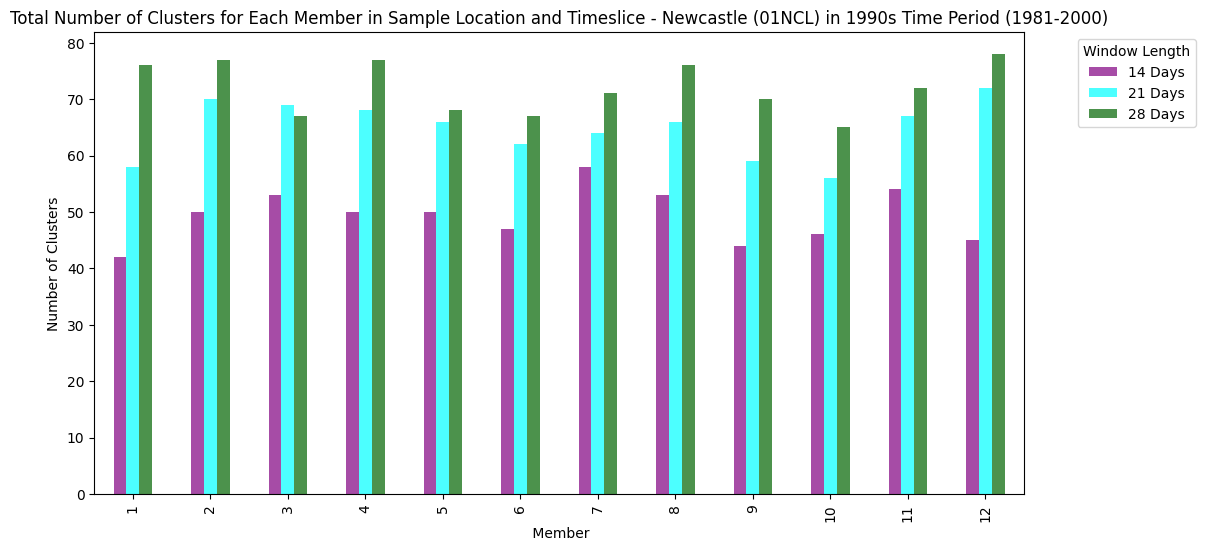

In [8]:
#Plotting Sample bar chart for cluster count
NCL01_1981_2000 = all_results.loc['01NCL_1981_2000']
NCL01_1981_2000_14Window = NCL01_1981_2000[NCL01_1981_2000['Window'] == 14]
NCL01_1981_2000_21Window = NCL01_1981_2000[NCL01_1981_2000['Window'] == 21]
NCL01_1981_2000_28Window = NCL01_1981_2000[NCL01_1981_2000['Window'] == 28]

member_clusters_14 = NCL01_1981_2000_14Window.groupby('Member')['Total Cluster Amount'].sum()
member_clusters_21 = NCL01_1981_2000_21Window.groupby('Member')['Total Cluster Amount'].sum()
member_clusters_28 = NCL01_1981_2000_28Window.groupby('Member')['Total Cluster Amount'].sum()

combined_clusters = pd.concat([member_clusters_14, member_clusters_21, member_clusters_28], axis=1, keys=['14 Days', '21 Days', '28 Days'])
colors = ['purple', 'cyan', 'darkgreen']

ax = combined_clusters.plot(kind='bar', color=colors, alpha=0.7, figsize=(12, 6))
plt.xlabel(' Member')
plt.ylabel('Number of Clusters')
plt.title('Total Number of Clusters for Each Member in Sample Location and Timeslice - Newcastle (01NCL) in 1990s Time Period (1981-2000)')
plt.legend(title='Window Length', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()



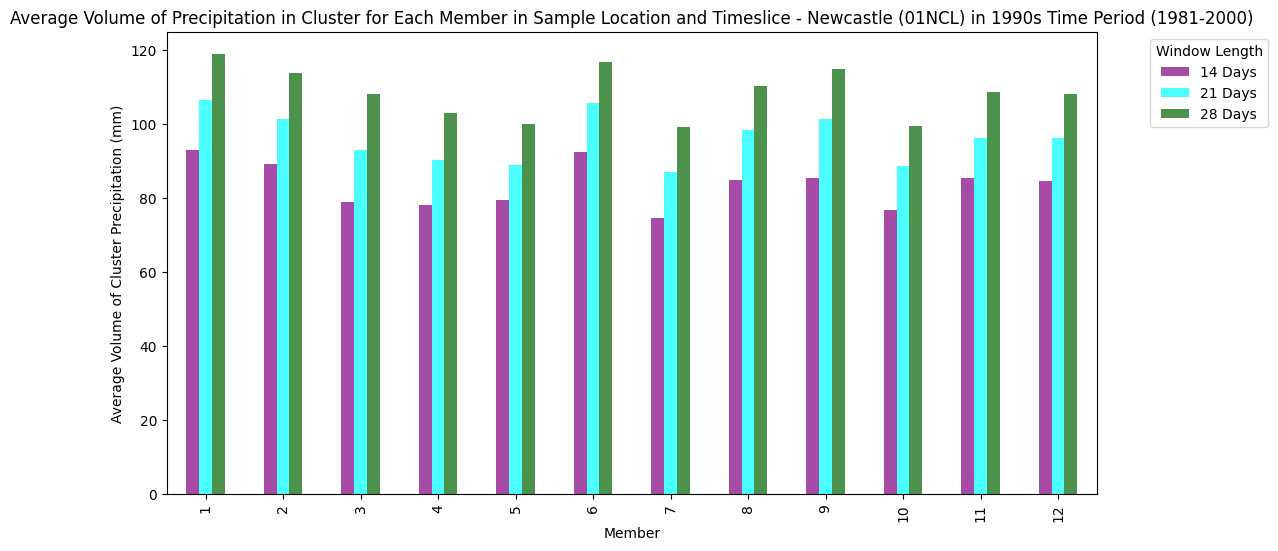

In [9]:
#Plotting Sample bar chart for average rolling window precipitation
member_avg_rolling_p_14 = NCL01_1981_2000_14Window.groupby('Member')['Avg Rolling Window P'].mean()
member_avg_rolling_p_21 = NCL01_1981_2000_21Window.groupby('Member')['Avg Rolling Window P'].mean()
member_avg_rolling_p_28 = NCL01_1981_2000_28Window.groupby('Member')['Avg Rolling Window P'].mean()

combined_avg_rolling_p = pd.concat([member_avg_rolling_p_14, member_avg_rolling_p_21, member_avg_rolling_p_28], axis=1, keys=['14 Days', '21 Days', '28 Days'])

ax = combined_avg_rolling_p.plot(kind='bar', alpha=0.7, color=['purple', 'cyan', 'darkgreen'], figsize=(12, 6))
plt.xlabel('Member')
plt.ylabel('Average Volume of Cluster Precipitation (mm)')
plt.title('Average Volume of Precipitation in Cluster for Each Member in Sample Location and Timeslice - Newcastle (01NCL) in 1990s Time Period (1981-2000)')
plt.legend(title='Window Length', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


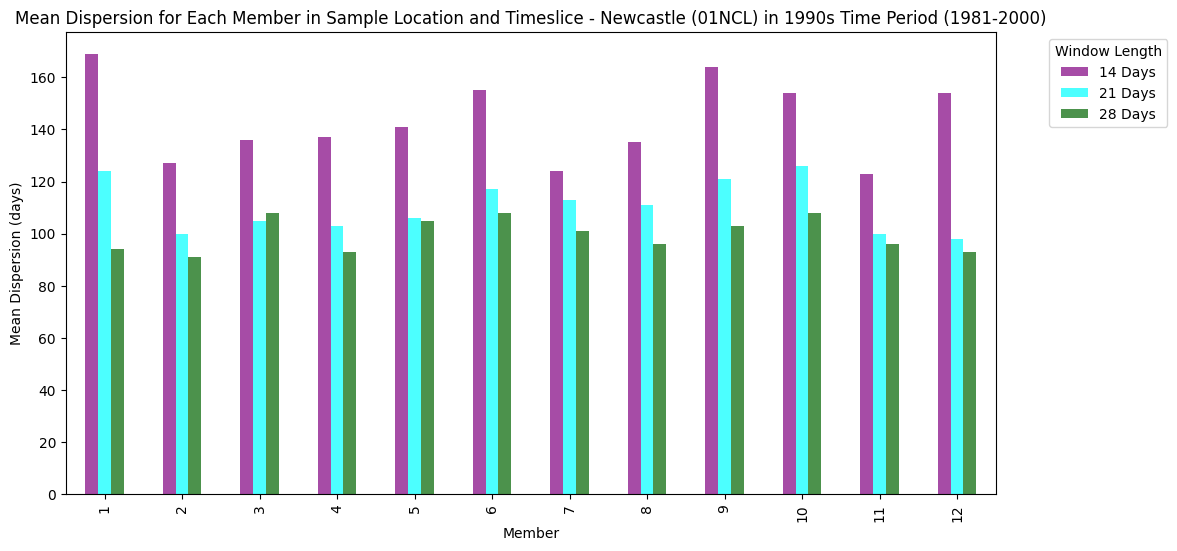

In [10]:
# Same again for dispersion
member_mean_dispersion_14 = NCL01_1981_2000_14Window.groupby('Member')['Mean Dispersion'].mean()
member_mean_dispersion_21 = NCL01_1981_2000_21Window.groupby('Member')['Mean Dispersion'].mean()
member_mean_dispersion_28 = NCL01_1981_2000_28Window.groupby('Member')['Mean Dispersion'].mean()

combined_mean_dispersion = pd.concat([member_mean_dispersion_14, member_mean_dispersion_21, member_mean_dispersion_28], axis=1, keys=['14 Days', '21 Days', '28 Days'])

ax = combined_mean_dispersion.plot(kind='bar', alpha=0.7, color=['purple', 'cyan', 'darkgreen'], figsize=(12, 6))
plt.xlabel('Member')
plt.ylabel('Mean Dispersion (days)')
plt.title('Mean Dispersion for Each Member in Sample Location and Timeslice - Newcastle (01NCL) in 1990s Time Period (1981-2000)')
plt.legend(title='Window Length', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()


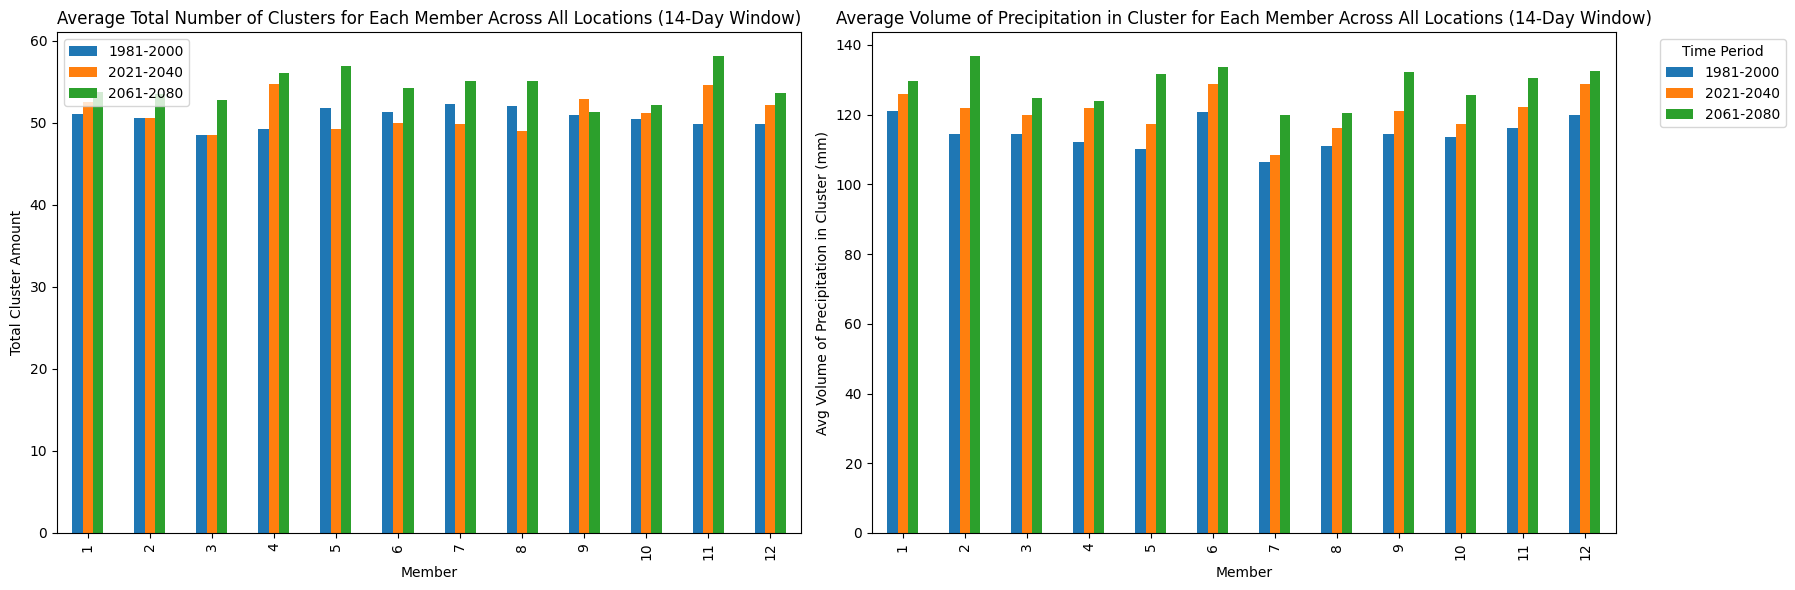

In [11]:
# Bar charts for individual members across time periods
all_14Window_1981_2000 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('1981_2000'))]
all_14Window_2021_2040 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('2021_2040'))]
all_14Window_2061_2080 = all_results[(all_results['Window'] == 14) & (all_results.index.str.contains('2061_2080'))]

member_clusters_1981_2000 = all_14Window_1981_2000.groupby(['Member', 'Location/Timeframe'])['Total Cluster Amount'].mean().reset_index().groupby('Member')['Total Cluster Amount'].mean()
member_clusters_2021_2040 = all_14Window_2021_2040.groupby(['Member', 'Location/Timeframe'])['Total Cluster Amount'].mean().reset_index().groupby('Member')['Total Cluster Amount'].mean()
member_clusters_2061_2080 = all_14Window_2061_2080.groupby(['Member', 'Location/Timeframe'])['Total Cluster Amount'].mean().reset_index().groupby('Member')['Total Cluster Amount'].mean()
member_avg_precip_1981_2000 = all_14Window_1981_2000.groupby(['Member', 'Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index().groupby('Member')['Avg Rolling Window P'].mean()
member_avg_precip_2021_2040 = all_14Window_2021_2040.groupby(['Member', 'Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index().groupby('Member')['Avg Rolling Window P'].mean()
member_avg_precip_2061_2080 = all_14Window_2061_2080.groupby(['Member', 'Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index().groupby('Member')['Avg Rolling Window P'].mean()

combined_avg_precip = pd.concat([member_avg_precip_1981_2000, member_avg_precip_2021_2040, member_avg_precip_2061_2080], axis=1, keys=['1981-2000', '2021-2040', '2061-2080'])
combined_clusters = pd.concat([member_clusters_1981_2000, member_clusters_2021_2040, member_clusters_2061_2080], axis=1, keys=['1981-2000', '2021-2040', '2061-2080'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))


combined_clusters.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Member')
axes[0].set_ylabel('Total Cluster Amount')
axes[0].set_title('Average Total Number of Clusters for Each Member Across All Locations (14-Day Window)')

combined_avg_precip.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Member')
axes[1].set_ylabel('Avg Volume of Precipitation in Cluster (mm)')
axes[1].set_title('Average Volume of Precipitation in Cluster for Each Member Across All Locations (14-Day Window)')

plt.legend(title='Time Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

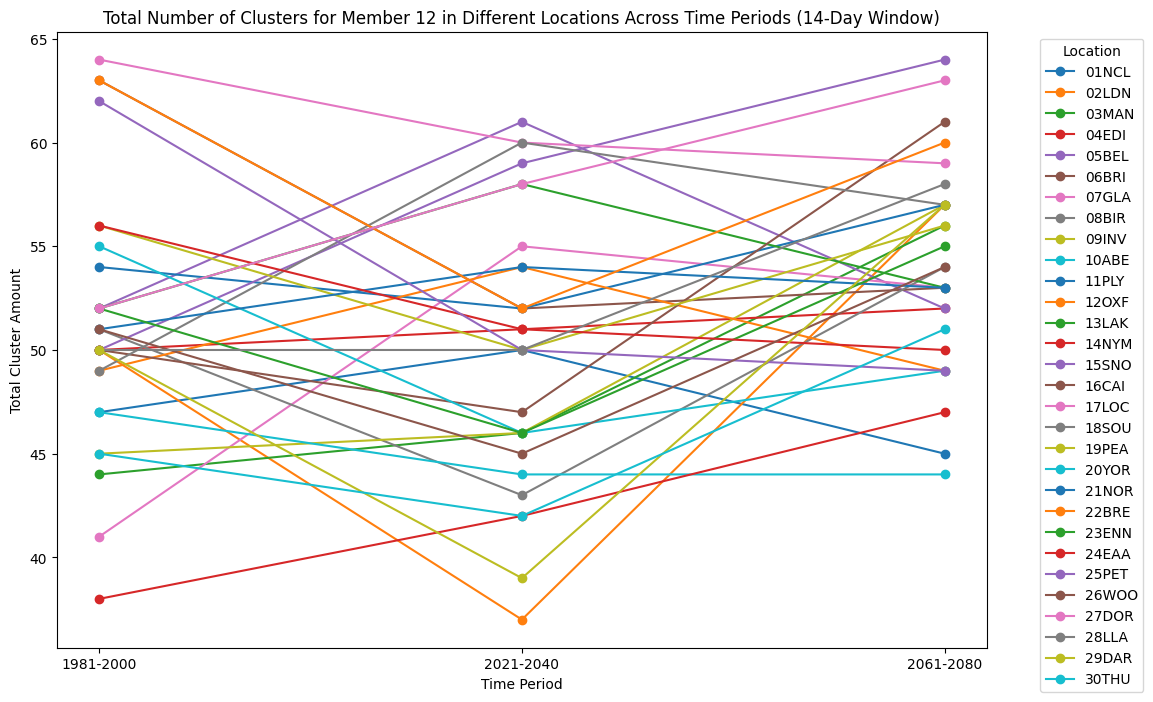

In [12]:
#Line graph for all 30 locations
member12_14Window = all_results[(all_results['Window'] == 14) & (all_results['Member'] == 6)]
clusters_by_location_period = member12_14Window.groupby(['Location/Timeframe'])['Total Cluster Amount'].sum().reset_index()
clusters_pivoted = clusters_by_location_period.pivot_table(values='Total Cluster Amount', index='Location/Timeframe', columns=None)

location_names = clusters_pivoted.index.str.split('_').str[0].unique()


clusters_by_location = {}
for location in location_names:
    location_data = clusters_pivoted.loc[clusters_pivoted.index.str.startswith(location)]
    clusters_by_location[location] = location_data

timeslice_labels = ['1981-2000', '2021-2040', '2061-2080']

fig, ax = plt.subplots(figsize=(12, 8))
for location, data in clusters_by_location.items():
    ax.plot(timeslice_labels, data.values, marker='o', label=location)
plt.xlabel('Time Period')
plt.ylabel('Total Cluster Amount')
plt.title('Total Number of Clusters for Member 12 in Different Locations Across Time Periods (14-Day Window)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


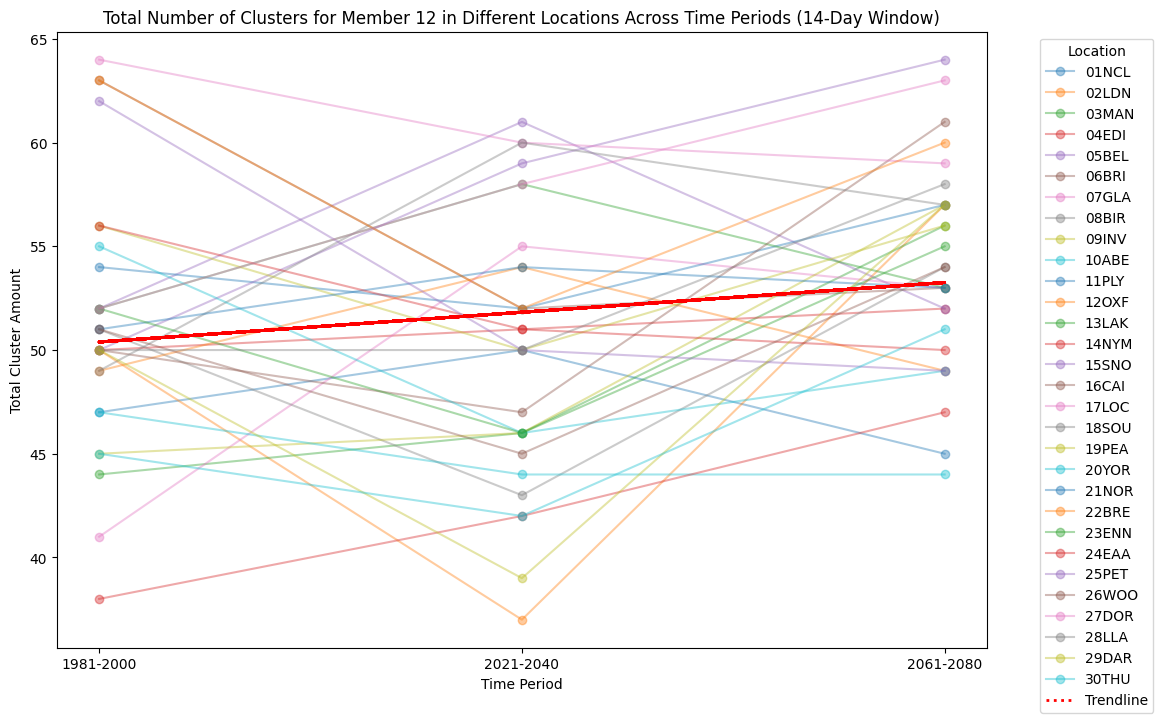

In [13]:
# Same as above but with linear trendline
x_numeric = [0, 1, 2]  

x_values = []
y_values = []
for location, data in clusters_by_location.items():
    x_values.extend(x_numeric)
    y_values.extend(data.values)

x_values = np.array(x_values).flatten()
y_values = np.array(y_values).flatten()

z = np.polyfit(x_values, y_values, 1)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize=(12, 8))
for location, data in clusters_by_location.items():
    ax.plot(x_numeric, data.values, marker='o', label=location, alpha=0.4)

ax.plot(x_values, p(x_values), "r:", label='Trendline', linewidth=2)

plt.xticks(ticks=x_numeric, labels=timeslice_labels)
plt.xlabel('Time Period')
plt.ylabel('Total Cluster Amount')
plt.title('Total Number of Clusters for Member 12 in Different Locations Across Time Periods (14-Day Window)')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


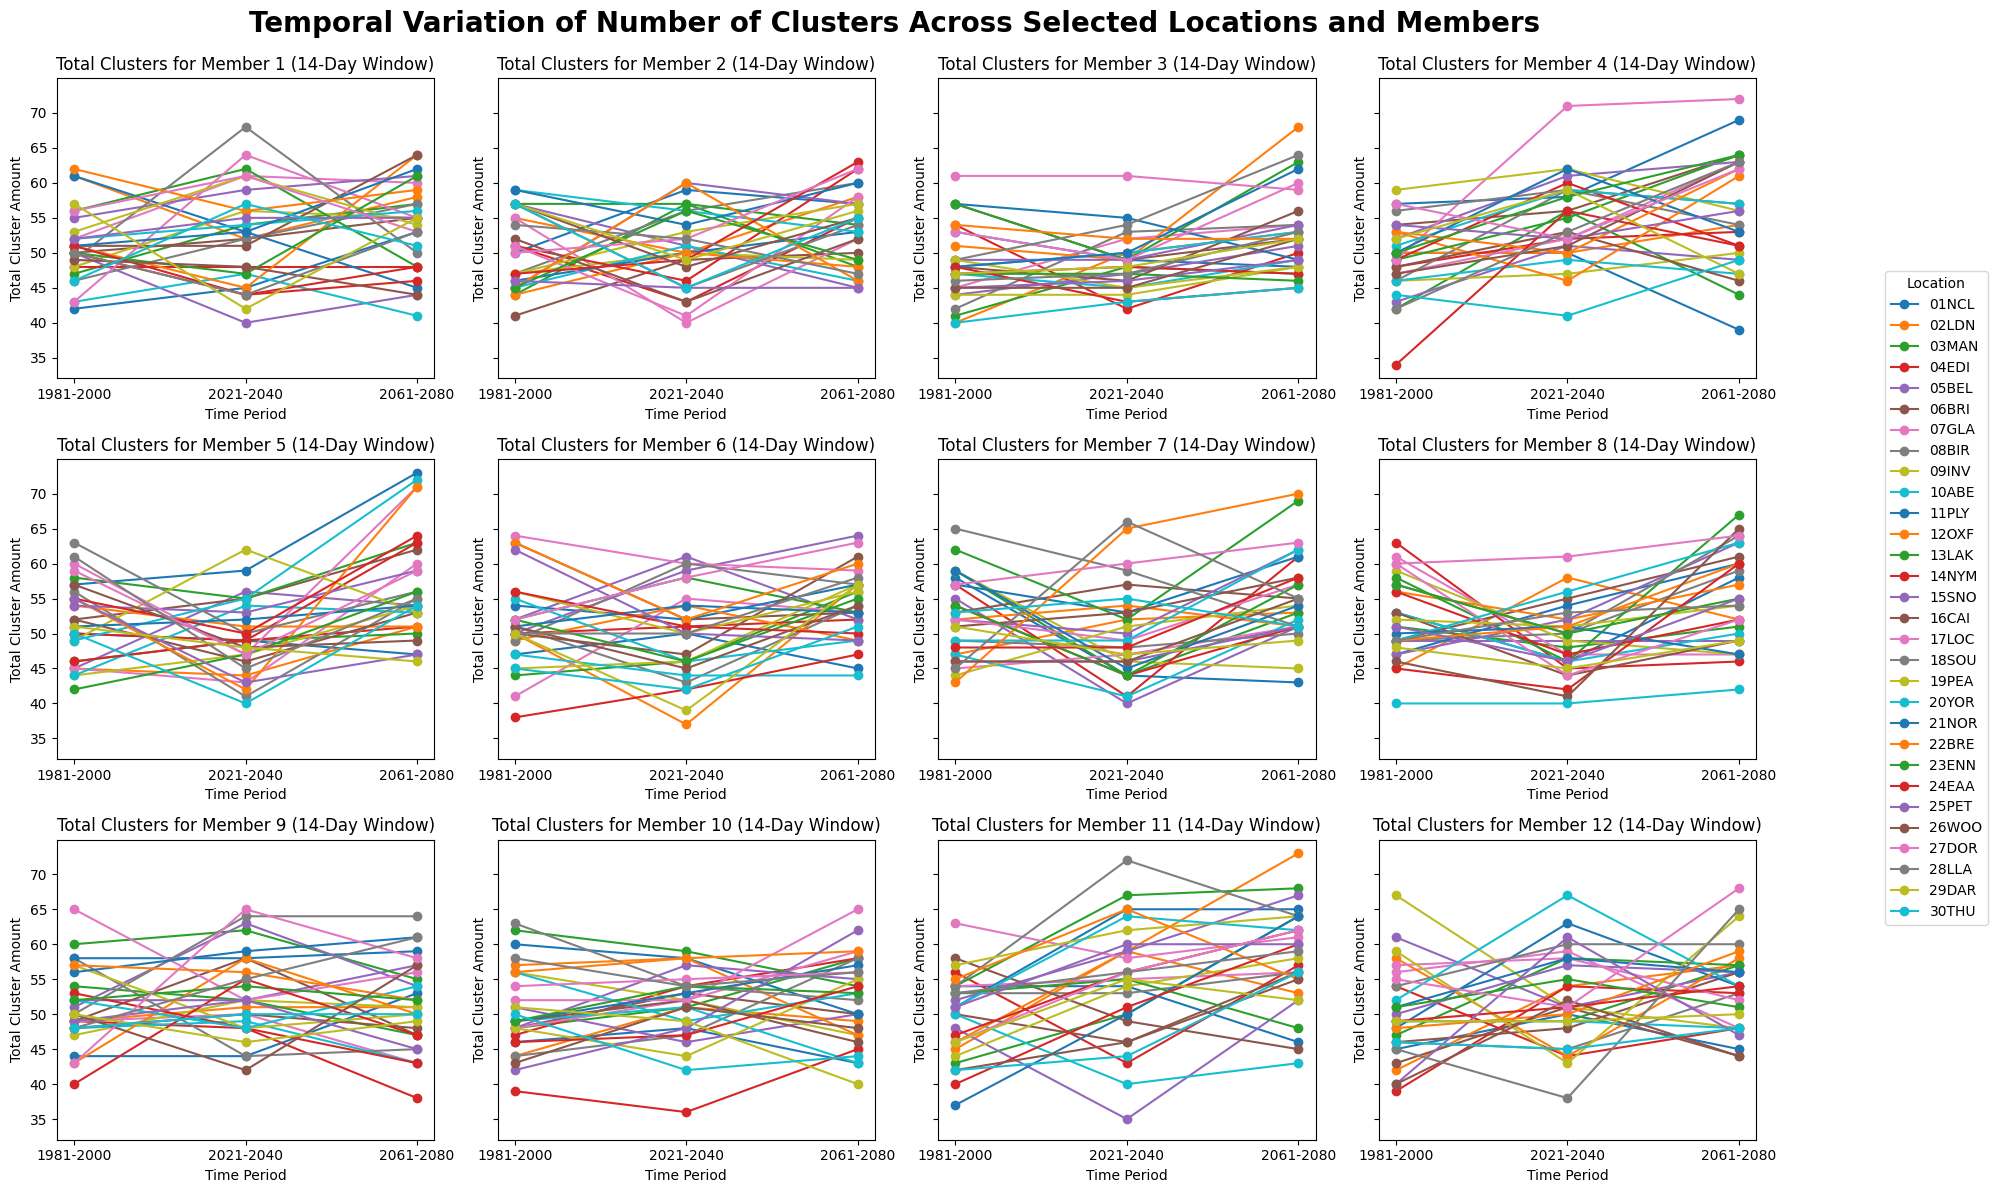

In [14]:
# Line graph loop for all 12 members and temporal variation
window_14 = all_results[all_results['Window'] == 14]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True)
axs = axs.flatten()

for member in range(1, 13):
    member_data = window_14[window_14['Member'] == member]

    clusters_by_location_period = member_data.groupby(['Location/Timeframe'])['Total Cluster Amount'].sum().reset_index()

    clusters_pivoted = clusters_by_location_period.pivot_table(values='Total Cluster Amount', index='Location/Timeframe', columns=None)

    location_names = clusters_pivoted.index.str.split('_').str[0].unique()

    clusters_by_location = {}
    for location in location_names:
        location_data = clusters_pivoted.loc[clusters_pivoted.index.str.startswith(location)]
        clusters_by_location[location] = location_data

    ax = axs[member-1]
    for location, data in clusters_by_location.items():
        ax.plot(timeslice_labels, data.values, marker='o', label=location)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Total Cluster Amount')
    ax.set_title(f'Total Clusters for Member {member} (14-Day Window)')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Location', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.0)

fig.suptitle('Temporal Variation of Number of Clusters Across Selected Locations and Members', fontsize=20, fontweight='bold', y=0.99)

plt.tight_layout()
plt.show()


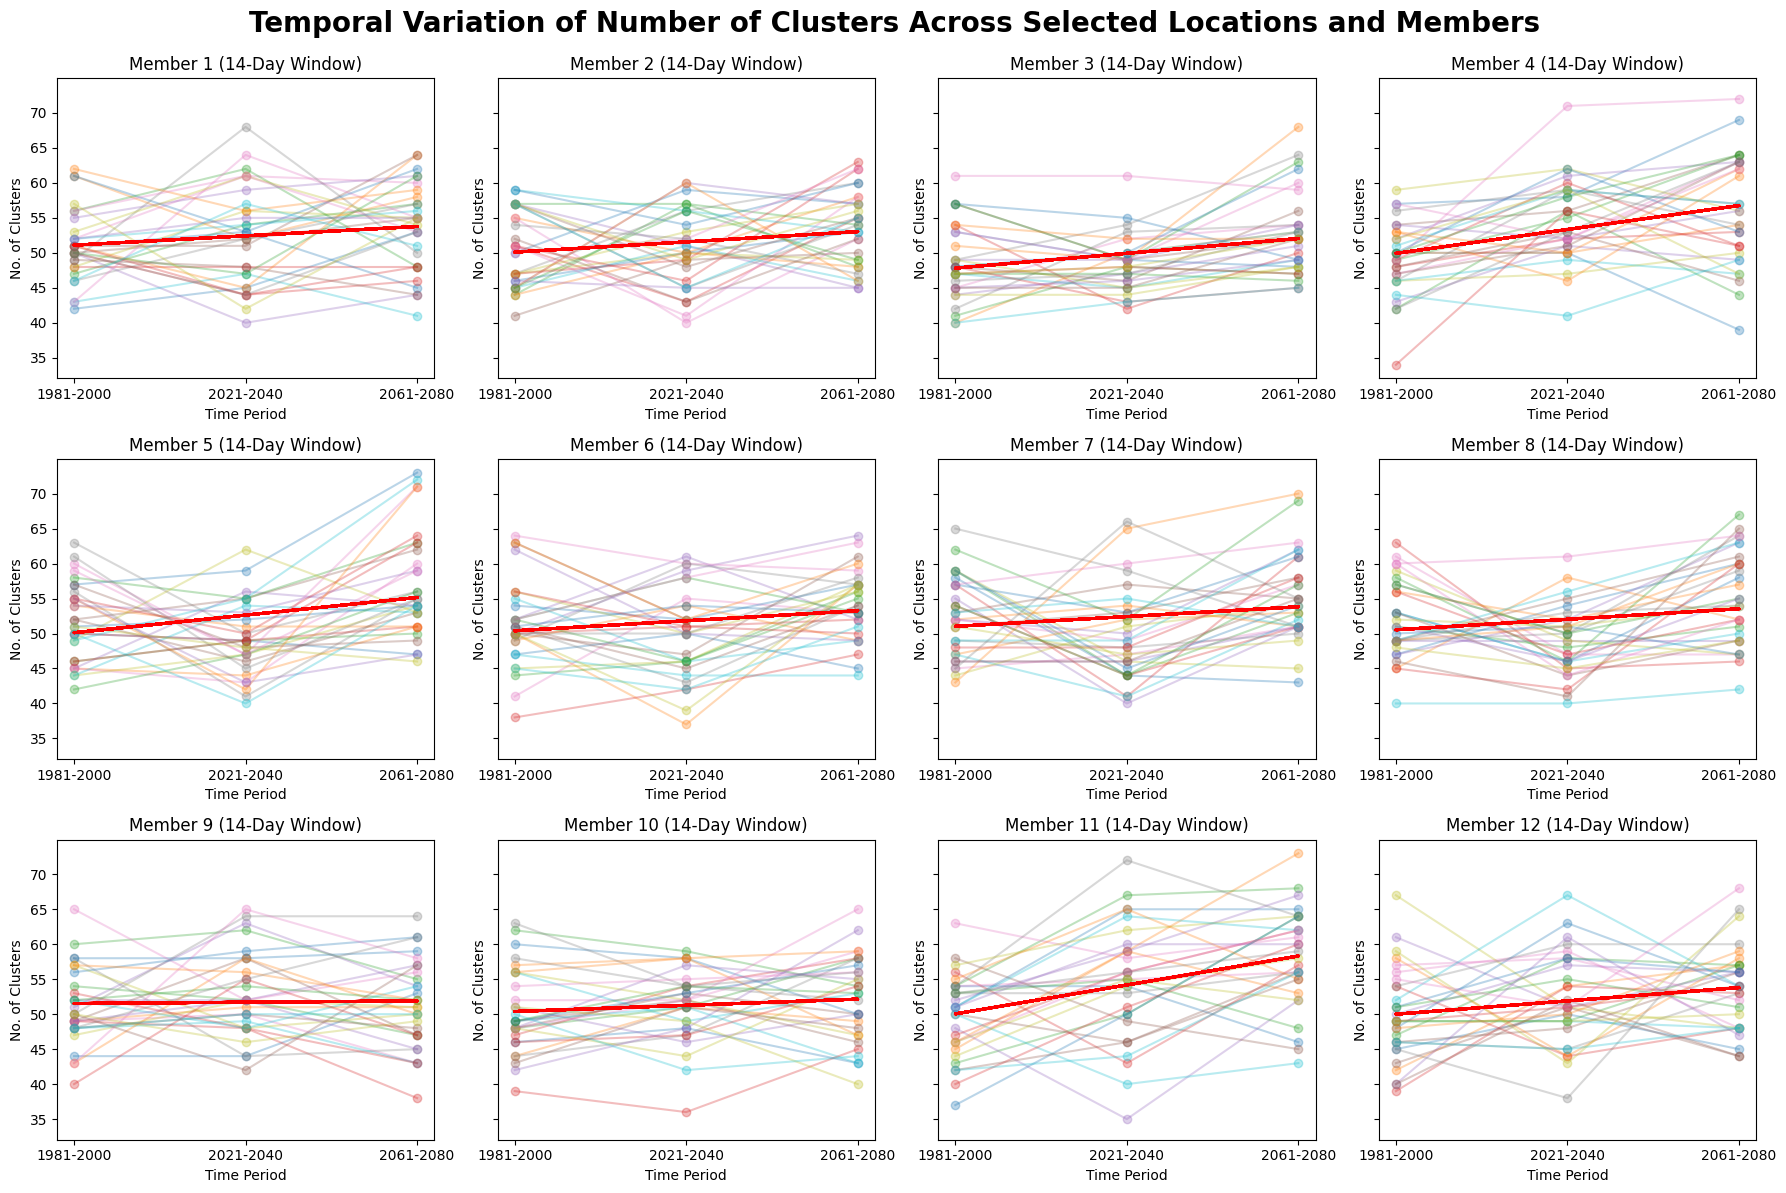

In [15]:
# Trend lines added for same as above
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True)
axs = axs.flatten()

for member in range(1, 13):
    member_data = window_14[window_14['Member'] == member]
    clusters_by_location_period = member_data.groupby(['Location/Timeframe'])['Total Cluster Amount'].sum().reset_index()
    clusters_pivoted = clusters_by_location_period.pivot_table(values='Total Cluster Amount', index='Location/Timeframe', columns=None)
    location_names = clusters_pivoted.index.str.split('_').str[0].unique()

    clusters_by_location = {}
    for location in location_names:
        location_data = clusters_pivoted.loc[clusters_pivoted.index.str.startswith(location)]
        clusters_by_location[location] = location_data

    x_values = []
    y_values = []
    for location, data in clusters_by_location.items():
        x_values.extend(x_numeric)
        y_values.extend(data.values)

    x_values = np.array(x_values).flatten()
    y_values = np.array(y_values).flatten()

    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)

    ax = axs[member-1]
    for location, data in clusters_by_location.items():
        ax.plot(x_numeric, data.values, marker='o', alpha=0.3)

    ax.plot(x_values, p(x_values), "r:", linewidth=2)
    ax.set_xticks(x_numeric)
    ax.set_xticklabels(timeslice_labels)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('No. of Clusters')
    ax.set_title(f'Member {member} (14-Day Window)')

fig.suptitle('Temporal Variation of Number of Clusters Across Selected Locations and Members', fontsize=20, fontweight='bold', y=0.99)

plt.tight_layout()
plt.show()

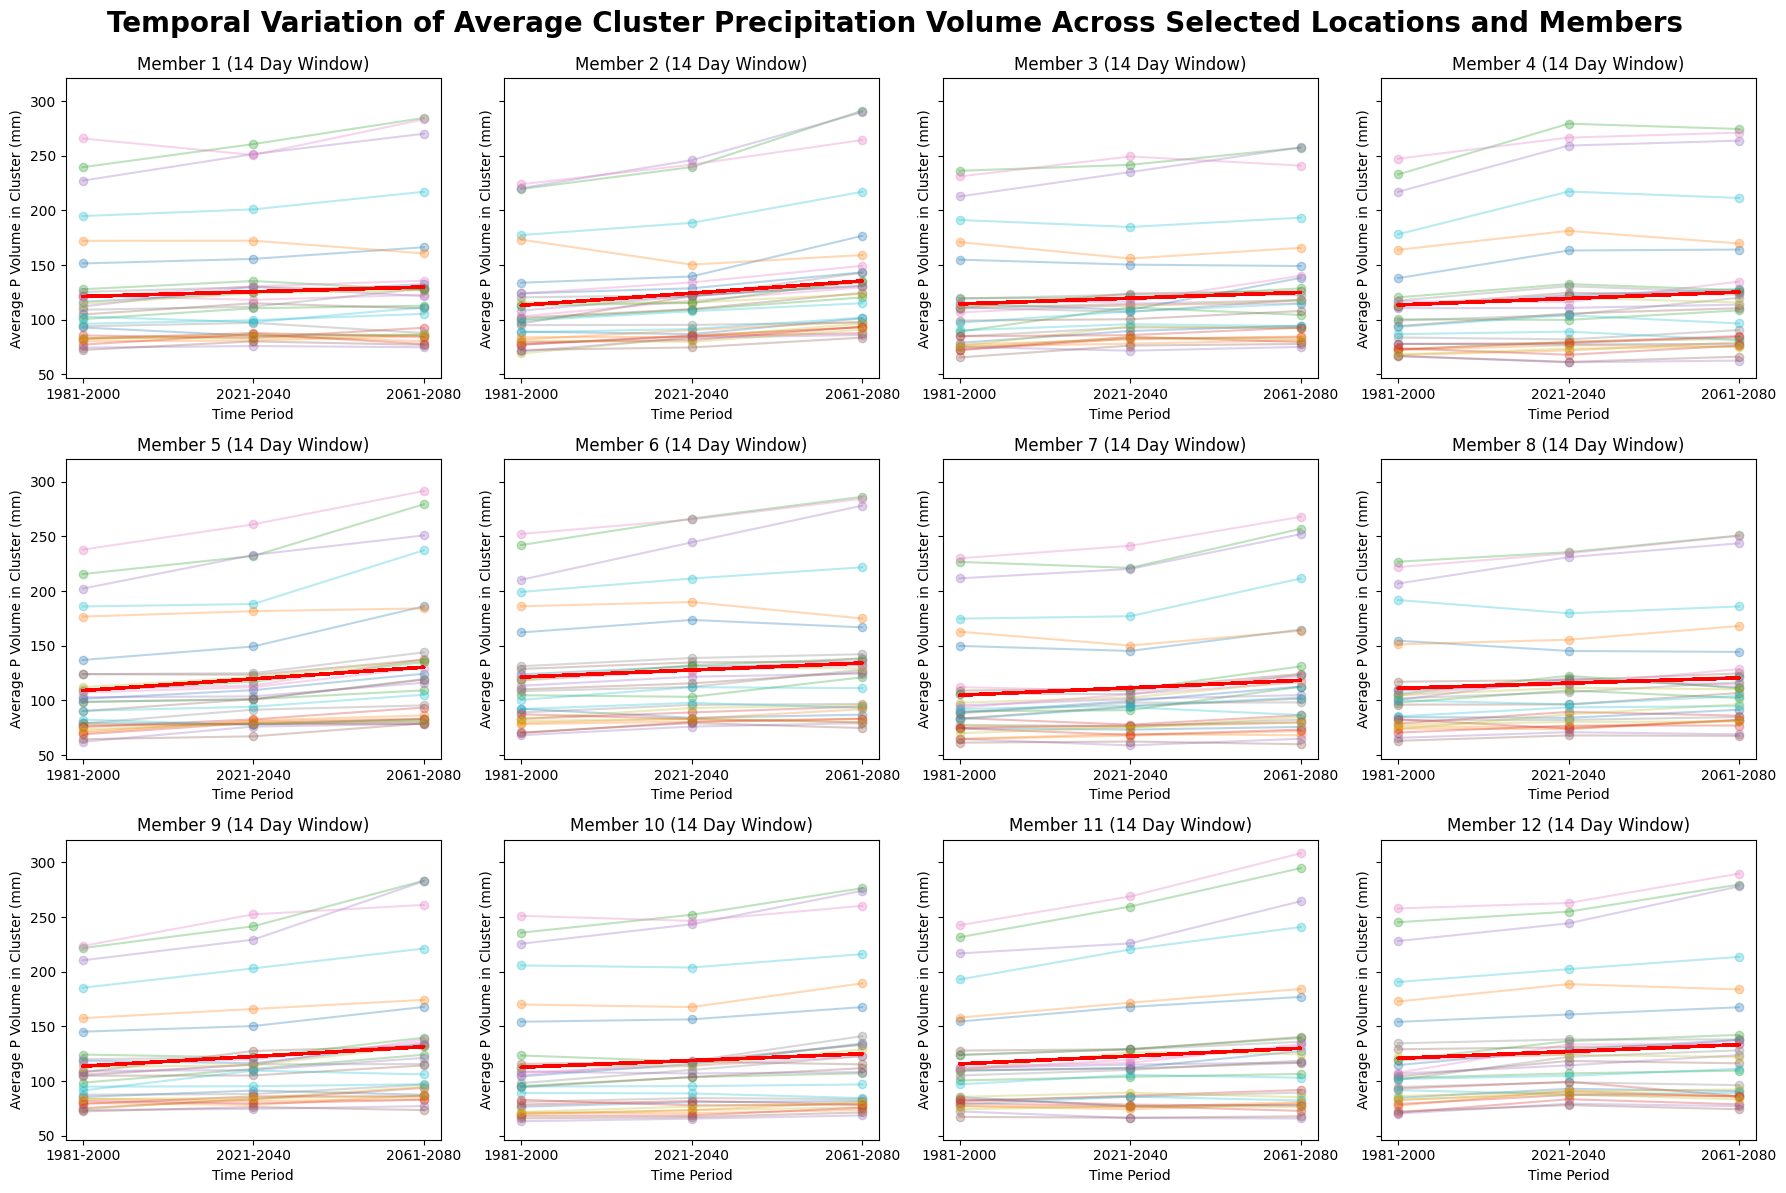

In [16]:
# Avg rolling window P line graphs
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True)
fig.suptitle('Average Rolling Window Precipitation Volume (14-Day Window)', fontsize=16, y=1.02)
axs = axs.flatten()

for member in range(1, 13):
    member_data = window_14[window_14['Member'] == member]

    # Group the data by 'Location/Timeframe' and calculate the average rolling window P
    avgP_by_location_period = member_data.groupby(['Location/Timeframe'])['Avg Rolling Window P'].mean().reset_index()

    # Pivot the data to have each location as a separate column
    avgP_pivoted = avgP_by_location_period.pivot_table(values='Avg Rolling Window P', index='Location/Timeframe', columns=None)

    # Extract the location names from the index
    location_names = avgP_pivoted.index.str.split('_').str[0].unique()

    # Create a dictionary to store average P by location
    avgP_by_location = {}
    for location in location_names:
        location_data = avgP_pivoted.loc[avgP_pivoted.index.str.startswith(location)]
        avgP_by_location[location] = location_data

    # Prepare data for scatter plot and trendline
    x_values = []
    y_values = []
    for location, data in avgP_by_location.items():
        x_values.extend(x_numeric)
        y_values.extend(data.values)

    # Convert x_values and y_values to 1D numpy arrays
    x_values = np.array(x_values).flatten()
    y_values = np.array(y_values).flatten()

    # Fit a linear regression model
    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)

    # Plot the line graph for the current member
    ax = axs[member-1]
    for location, data in avgP_by_location.items():
        ax.plot(x_numeric, data.values, marker='o', alpha=0.3)

    # Plot the trendline
    ax.plot(x_values, p(x_values), "r:", linewidth=2)
    ax.set_xticks(x_numeric)
    ax.set_xticklabels(timeslice_labels)
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Average P Volume in Cluster (mm)')
    ax.set_title(f'Member {member} (14 Day Window)', fontsize=12)

fig.suptitle('Temporal Variation of Average Cluster Precipitation Volume Across Selected Locations and Members', fontsize=20, fontweight='bold', y=0.99)

plt.tight_layout()
plt.show()

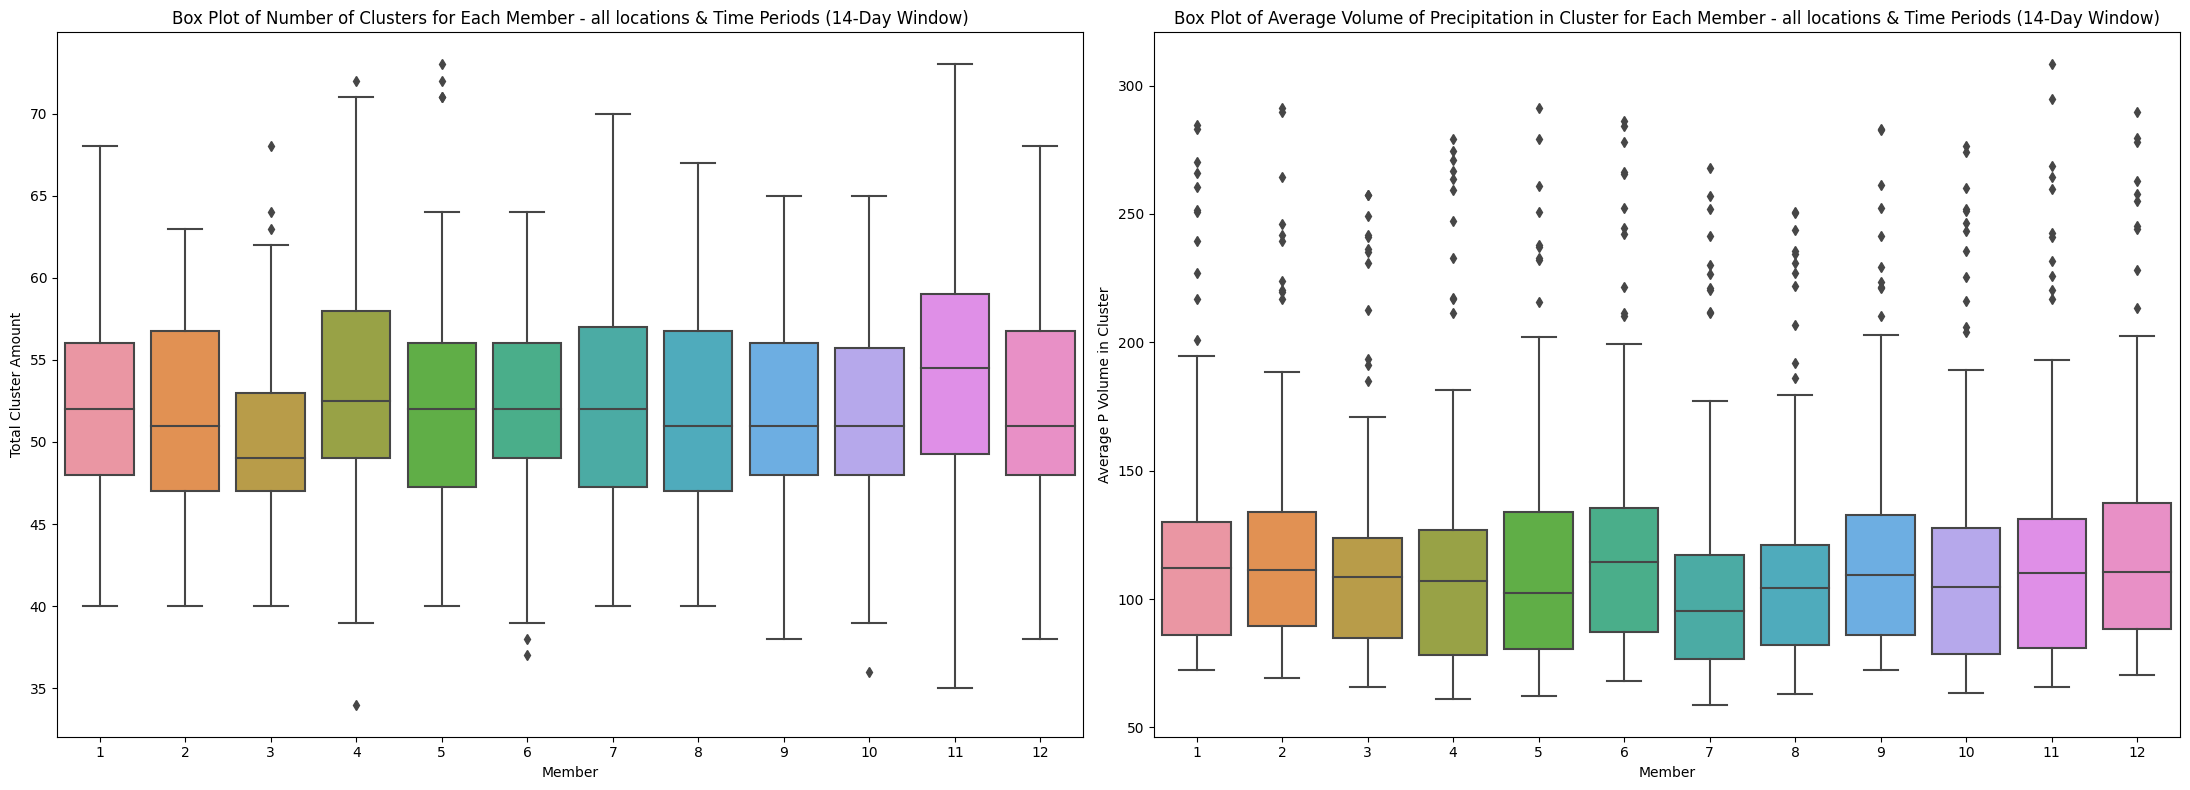

In [17]:
# Create a box plot with 'Member' on the x-axis and 'Total Cluster Amount' on the y-axis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

sns.boxplot(x='Member', y='Total Cluster Amount', data=window_14, ax=ax1)
ax1.set_xlabel('Member')
ax1.set_ylabel('Total Cluster Amount')
ax1.set_title('Box Plot of Number of Clusters for Each Member - all locations & Time Periods (14-Day Window)')

sns.boxplot(x='Member', y='Avg Rolling Window P', data=window_14, ax=ax2)
ax2.set_xlabel('Member')
ax2.set_ylabel('Average P Volume in Cluster')
ax2.set_title('Box Plot of Average Volume of Precipitation in Cluster for Each Member - all locations & Time Periods (14-Day Window)')

plt.tight_layout()
plt.show()

In [18]:
# Filter for the desired window size
all_results_window14 = all_results[all_results['Window'] == 14]

# Pivot the data
clusterpivot_df = all_results_window14.pivot_table(index='Location/Timeframe', columns='Member', values='Total Cluster Amount')
rollingPpivot_df = all_results_window14.pivot_table(index='Location/Timeframe', columns='Member', values='Avg Rolling Window P')
mean_dispersion_pivot = all_results_window14.pivot_table(index='Location/Timeframe', columns='Member', values='Mean Dispersion')


# Get unique locations
locations = all_results_window14.index.str.split('_').str[0].unique()

# Prepare dictionaries to store the results
totalclusterdelta_dict = {}
totalclusterpercent_dict = {}
avgRollingPdelta_dict = {}
avgRollingPpercent_dict = {}
mean_dispersion_delta_dict = {}
mean_dispersion_percent_dict = {}

# Calculate the delta and percentage change for each location
for location in locations:
    # Get the data for the current location
    clusterlocation_data = clusterpivot_df.loc[clusterpivot_df.index.str.startswith(location)]
    rollinglocation_data = rollingPpivot_df.loc[rollingPpivot_df.index.str.startswith(location)]
    mean_dispersion_location_data = mean_dispersion_pivot.loc[mean_dispersion_pivot.index.str.startswith(location)]

    # Calculate the delta between '2061-2080' and '1981-2000'
    deltacluster = clusterlocation_data.loc[location + '_2061_2080'] - clusterlocation_data.loc[location + '_1981_2000']
    deltaRollingP = rollinglocation_data.loc[location + '_2061_2080'] - rollinglocation_data.loc[location + '_1981_2000']
    delta_mean_dispersion = mean_dispersion_location_data.loc[location + '_2061_2080'] - mean_dispersion_location_data.loc[location + '_1981_2000']

    # Append the result to the delta dictionary
    totalclusterdelta_dict[location] = deltacluster
    avgRollingPdelta_dict[location] = deltaRollingP
    mean_dispersion_delta_dict[location] = delta_mean_dispersion

    # Calculate the percentage change
    clusterpercent_change = (deltacluster / clusterlocation_data.loc[location + '_1981_2000']) * 100
    rollingpercent_change = (deltaRollingP / rollinglocation_data.loc[location + '_1981_2000']) * 100
    mean_dispersion_percent_change = (delta_mean_dispersion / mean_dispersion_location_data.loc[location + '_1981_2000']) * 100

    # Append the result to the percentage change dictionary
    totalclusterpercent_dict[location] = clusterpercent_change
    avgRollingPpercent_dict[location] = rollingpercent_change
    mean_dispersion_percent_dict[location] = mean_dispersion_percent_change

# Convert the dictionaries to DataFrames
deltatotalcluster_df = pd.DataFrame(totalclusterdelta_dict).T
percenttotalcluster_df = pd.DataFrame(totalclusterpercent_dict).T
deltaAvgRollingP_df = pd.DataFrame(avgRollingPdelta_dict).T
percentAvgRollingP_df = pd.DataFrame(avgRollingPpercent_dict).T
delta_mean_dispersion_df = pd.DataFrame(mean_dispersion_delta_dict).T
percent_mean_dispersion_df = pd.DataFrame(mean_dispersion_percent_dict).T

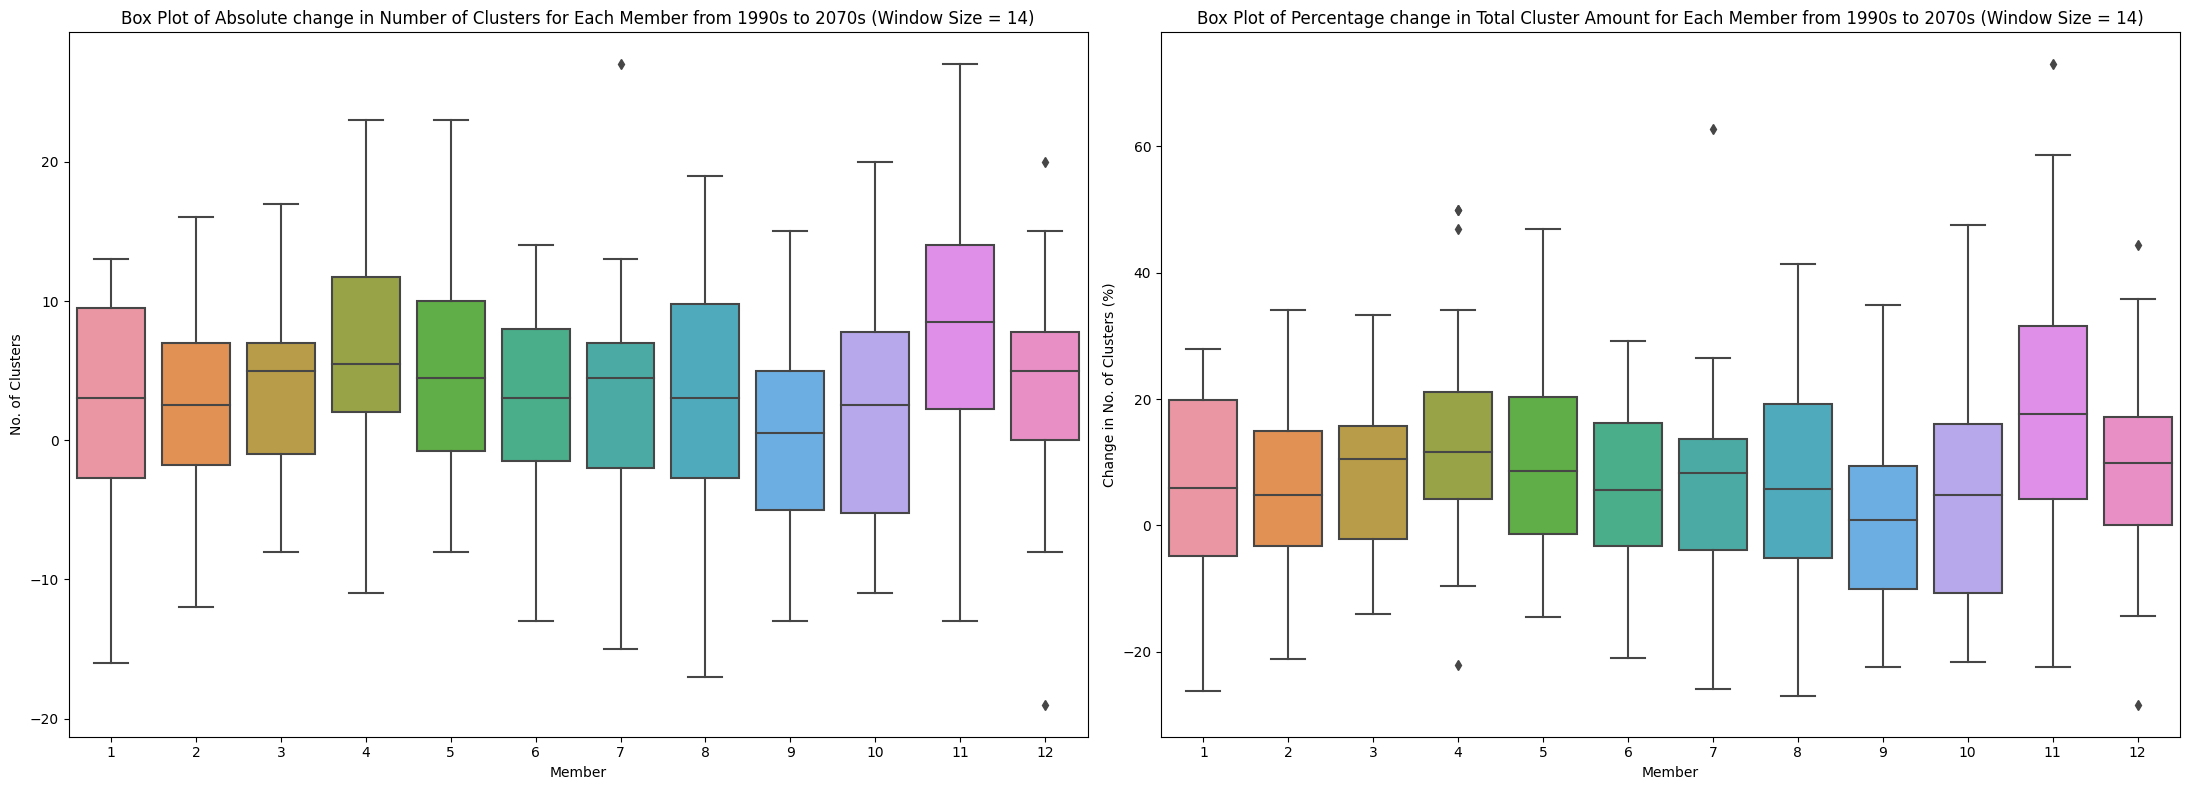

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Boxplot 1: deltatotalcluster_df
sns.boxplot(data=deltatotalcluster_df, ax=axes[0])
axes[0].set_xticklabels(deltatotalcluster_df.columns)
axes[0].set_title('Box Plot of Absolute change in Number of Clusters for Each Member from 1990s to 2070s (Window Size = 14)')
axes[0].set_ylabel('No. of Clusters')
axes[0].set_xlabel('Member')

# Boxplot 2: percenttotalcluster_df
sns.boxplot(data=percenttotalcluster_df, ax=axes[1])
axes[1].set_xticklabels(percenttotalcluster_df.columns)
axes[1].set_title('Box Plot of Percentage change in Total Cluster Amount for Each Member from 1990s to 2070s (Window Size = 14)')
axes[1].set_ylabel('Change in No. of Clusters (%)')
axes[1].set_xlabel('Member')

plt.tight_layout()
plt.show()

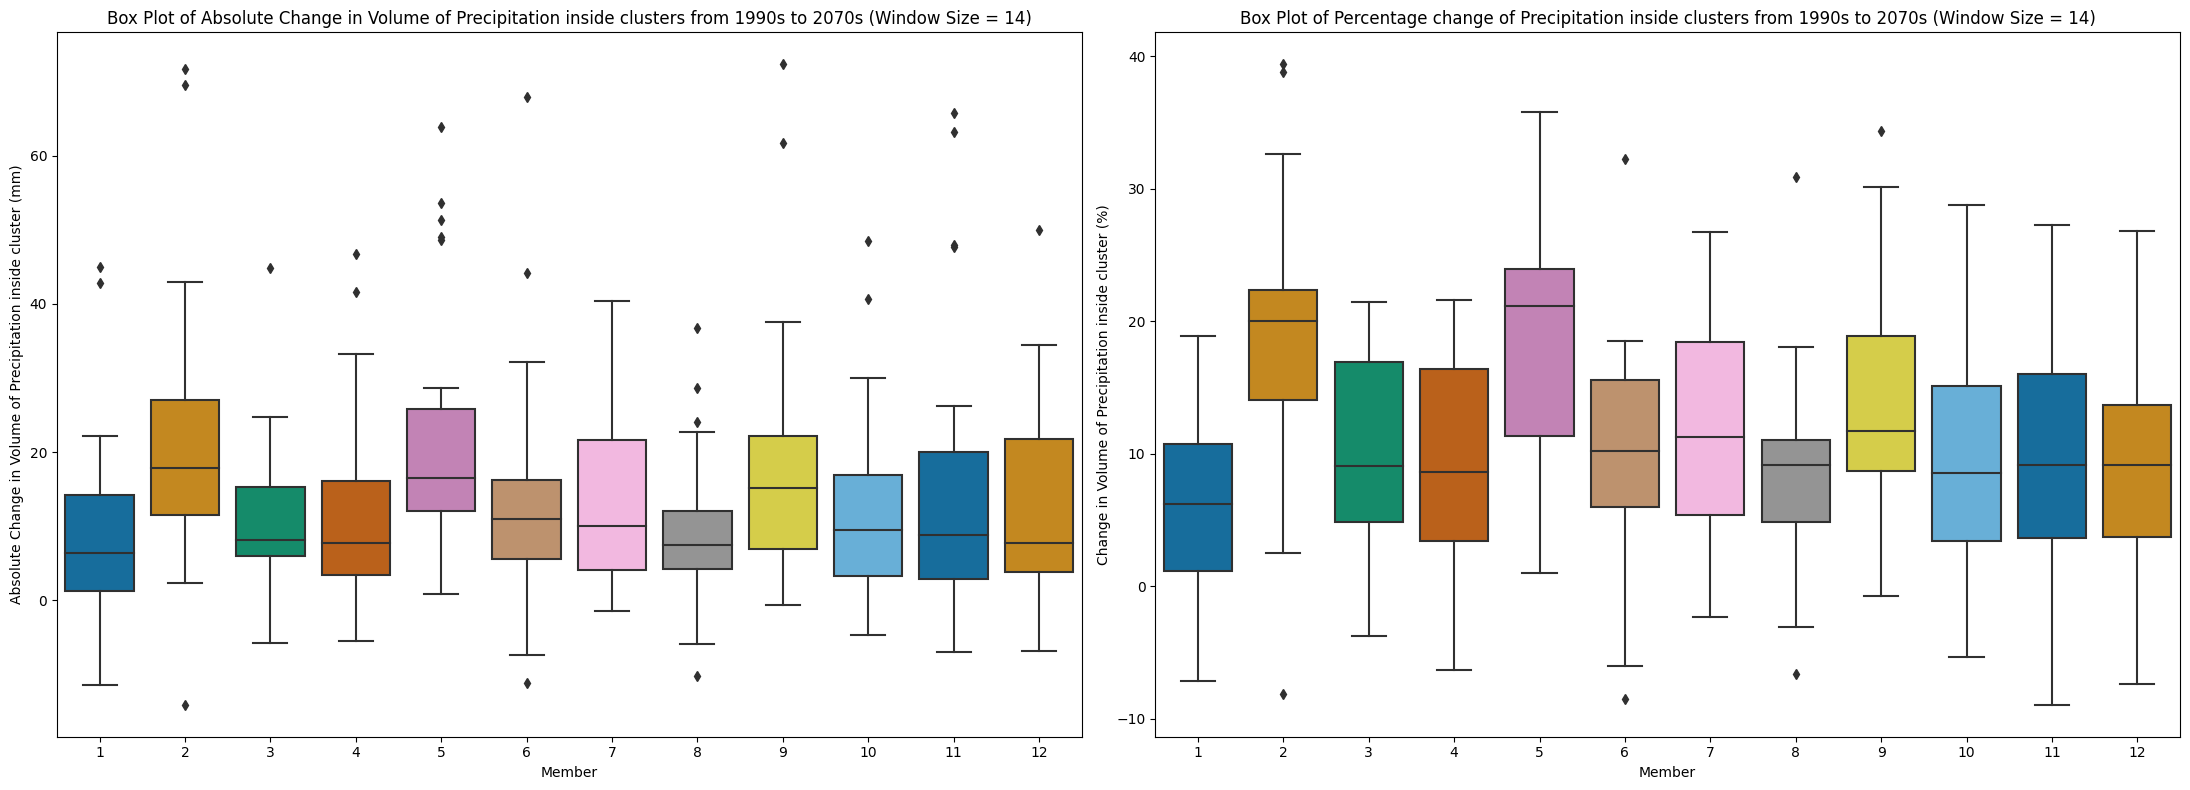

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Boxplot 1: deltaAvgRollingP_df
sns.boxplot(data=deltaAvgRollingP_df, ax=axes[0], palette='colorblind')
axes[0].set_xticklabels(deltaAvgRollingP_df.columns)
axes[0].set_title('Box Plot of Absolute Change in Volume of Precipitation inside clusters from 1990s to 2070s (Window Size = 14)')
axes[0].set_ylabel('Absolute Change in Volume of Precipitation inside cluster (mm)')
axes[0].set_xlabel('Member')

# Boxplot 2: percentAvgRollingP_df
sns.boxplot(data=percentAvgRollingP_df, ax=axes[1], palette='colorblind')
axes[1].set_xticklabels(percentAvgRollingP_df.columns)
axes[1].set_title('Box Plot of Percentage change of Precipitation inside clusters from 1990s to 2070s (Window Size = 14)')
axes[1].set_ylabel('Change in Volume of Precipitation inside cluster (%)')
axes[1].set_xlabel('Member')

plt.tight_layout()
plt.show()

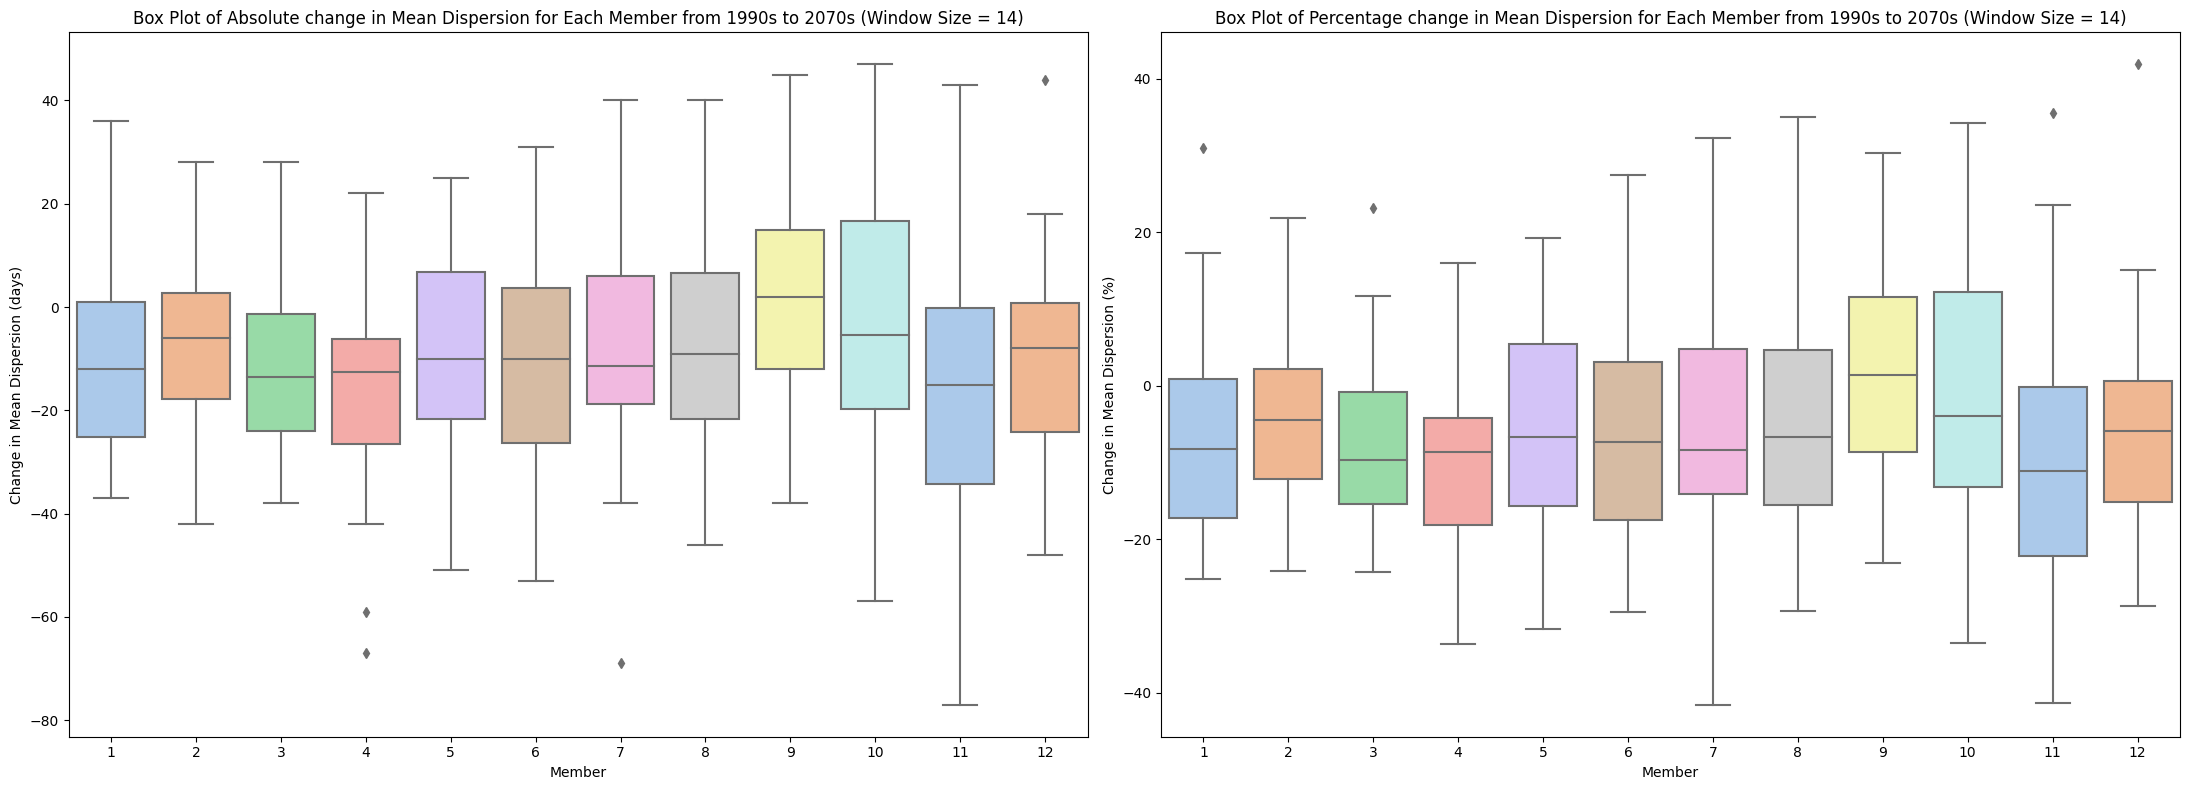

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Boxplot 1: delta_mean_dispersion_df
sns.boxplot(data=delta_mean_dispersion_df, ax=axes[0], palette='pastel')
axes[0].set_xticklabels(delta_mean_dispersion_df.columns)
axes[0].set_title('Box Plot of Absolute change in Mean Dispersion for Each Member from 1990s to 2070s (Window Size = 14)')
axes[0].set_ylabel('Change in Mean Dispersion (days)')
axes[0].set_xlabel('Member')

# Boxplot 2: mean_dispersion_percent_dict_df
mean_dispersion_percent_dict_df = pd.DataFrame(mean_dispersion_percent_dict).T
sns.boxplot(data=mean_dispersion_percent_dict_df, ax=axes[1], palette='pastel')
axes[1].set_xticklabels(mean_dispersion_percent_dict_df.columns)
axes[1].set_title('Box Plot of Percentage change in Mean Dispersion for Each Member from 1990s to 2070s (Window Size = 14)')
axes[1].set_ylabel('Change in Mean Dispersion (%)')
axes[1].set_xlabel('Member')

plt.tight_layout()
plt.show()   


<ipython-input-22-c4e9f3dfbed7>:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_results_member12['Longitude'], all_results_member12['Latitude'] = transform(inProj, outProj, all_results_member12['coord1'], all_results_member12['coord2'])
<ipython-input-22-c4e9f3dfbed7>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap('magma_r')
<ipython-input-22-c4e9f3dfbed7>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('viridis_r')


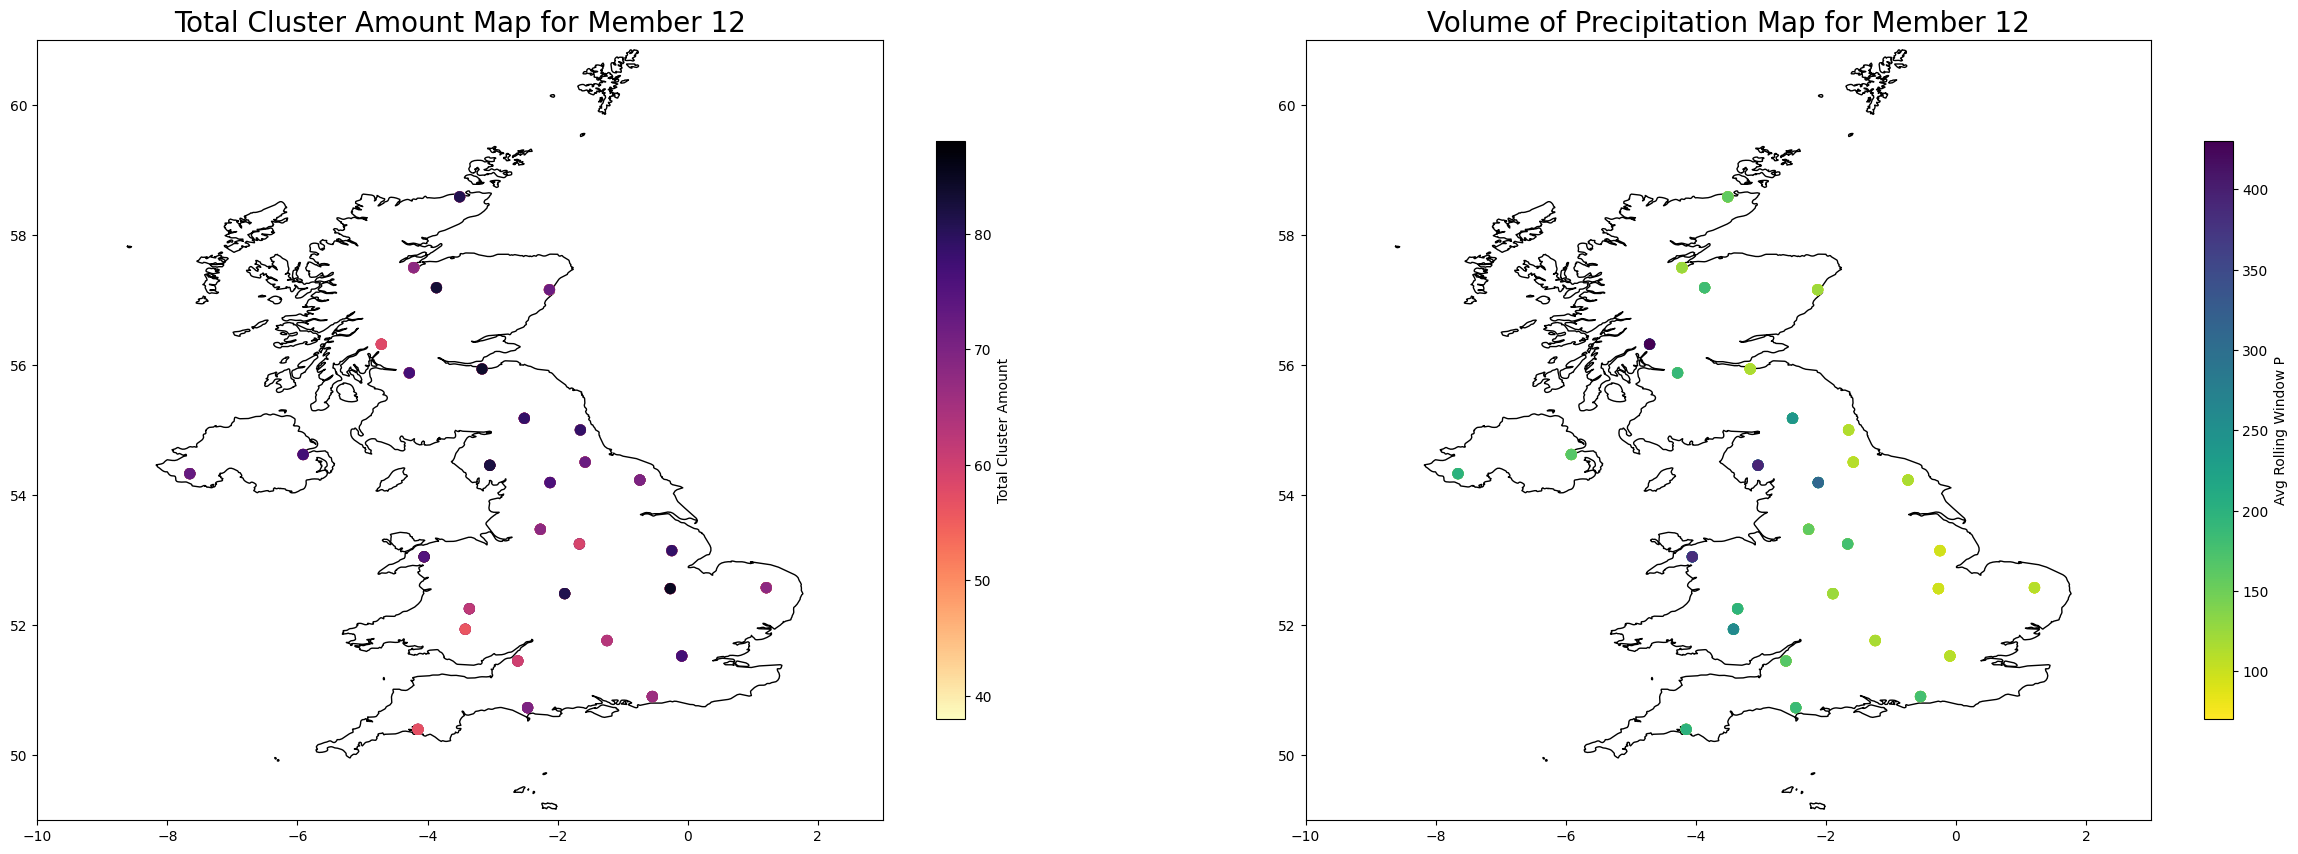

In [22]:
inProj = Proj('epsg:27700')  # British National Grid
outProj = Proj('epsg:4326')  # WGS84

#Transforming coordinates
all_results_member12 = all_results[all_results['Member'] == 12].copy()
all_results_member12[['coord1', 'coord2']] = pd.DataFrame(all_results_member12['Coordinates'].tolist(), index=all_results_member12.index)
all_results_member12['Longitude'], all_results_member12['Latitude'] = transform(inProj, outProj, all_results_member12['coord1'], all_results_member12['coord2'])
geometry = [Point(xy) for xy in zip(all_results_member12['Latitude'], all_results_member12['Longitude'])]
gdf_member12 = gpd.GeoDataFrame(all_results_member12, geometry=geometry)

# UK shapefile
gdf_uk = gpd.read_file('/content/drive/MyDrive/ne_10m_admin_0_countries.zip')
uk = gdf_uk[gdf_uk['SOVEREIGNT'] == 'United Kingdom']

fig, axs = plt.subplots(1, 2, figsize=(30,25))

# Plot for 'Total Cluster Amount'
norm1 = mcolors.Normalize(vmin=all_results_member12['Total Cluster Amount'].min(), vmax=all_results_member12['Total Cluster Amount'].max())
cmap1 = plt.cm.get_cmap('magma_r') 
all_results_member12['Color1'] = [cmap1(norm1(value)) for value in all_results_member12['Total Cluster Amount']]

axs[0].set_xlim(-10, 3)  
axs[0].set_ylim(49, 61)  
axs[0].set_title("Total Cluster Amount Map for Member 12", fontsize=20)

uk.plot(ax=axs[0], color='white', edgecolor='black')
gdf_member12.plot(ax=axs[0], markersize=50, color=all_results_member12['Color1'], marker='o') 

sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1.set_array([])
fig.colorbar(sm1, ax=axs[0], orientation='vertical', label='Total Cluster Amount', shrink=0.3)

# Plot for 'Avg Rolling Window P'
norm2 = mcolors.Normalize(vmin=all_results_member12['Avg Rolling Window P'].min(), vmax=all_results_member12['Avg Rolling Window P'].max())
cmap2 = plt.cm.get_cmap('viridis_r') 
all_results_member12['Color2'] = [cmap2(norm2(value)) for value in all_results_member12['Avg Rolling Window P']]

axs[1].set_xlim(-10, 3) 
axs[1].set_ylim(49, 61) 
axs[1].set_title("Volume of Precipitation Map for Member 12", fontsize=20)

uk.plot(ax=axs[1], color='white', edgecolor='black')
gdf_member12.plot(ax=axs[1], markersize=50, color=all_results_member12['Color2'], marker='o') 

sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2.set_array([])
fig.colorbar(sm2, ax=axs[1], orientation='vertical', label='Avg Rolling Window P', shrink=0.3)

plt.show()

In [23]:
#Sorting out mean and percentile member data formaps
mean_14_1981_2000 = all_14Window_1981_2000.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': 'mean',
    'Avg Rolling Window P': 'mean',
    'Mean Dispersion': 'mean',
    'Coordinates': 'first'  
}).reset_index()

mean_14_2021_2040 = all_14Window_2021_2040.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': 'mean',
    'Avg Rolling Window P': 'mean',
    'Mean Dispersion': 'mean',
    'Coordinates': 'first' 
}).reset_index()

mean_14_2061_2080 = all_14Window_2061_2080.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': 'mean',
    'Avg Rolling Window P': 'mean',
    'Mean Dispersion': 'mean',
    'Coordinates': 'first' 
}).reset_index()

mean_14_1981_2000[['coord1', 'coord2']] = pd.DataFrame(mean_14_1981_2000['Coordinates'].tolist(), index=mean_14_1981_2000.index)
mean_14_2021_2040[['coord1', 'coord2']] = pd.DataFrame(mean_14_2021_2040['Coordinates'].tolist(), index=mean_14_2021_2040.index)
mean_14_2061_2080[['coord1', 'coord2']] = pd.DataFrame(mean_14_2061_2080['Coordinates'].tolist(), index=mean_14_2061_2080.index)

p95_14_1981_2000 = all_14Window_1981_2000.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': lambda x: np.percentile(x, 95),
    'Avg Rolling Window P': lambda x: np.percentile(x, 95),
    'Mean Dispersion': lambda x: np.percentile(x, 95),
    'Coordinates': 'first'  
}).reset_index()

p95_14_2021_2040 = all_14Window_2021_2040.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': lambda x: np.percentile(x, 95),
    'Avg Rolling Window P': lambda x: np.percentile(x, 95),
    'Mean Dispersion': lambda x: np.percentile(x, 95),
    'Coordinates': 'first' 
}).reset_index()

p95_14_2061_2080 = all_14Window_2061_2080.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': lambda x: np.percentile(x, 95),
    'Avg Rolling Window P': lambda x: np.percentile(x, 95),
    'Mean Dispersion': lambda x: np.percentile(x, 95),
    'Coordinates': 'first' 
}).reset_index()

p95_14_1981_2000[['coord1', 'coord2']] = pd.DataFrame(p95_14_1981_2000['Coordinates'].tolist(), index=p95_14_1981_2000.index)
p95_14_2021_2040[['coord1', 'coord2']] = pd.DataFrame(p95_14_2021_2040['Coordinates'].tolist(), index=p95_14_2021_2040.index)
p95_14_2061_2080[['coord1', 'coord2']] = pd.DataFrame(p95_14_2061_2080['Coordinates'].tolist(), index=p95_14_2061_2080.index)

percentiles_14_2061_2080 = all_14Window_2061_2080.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Avg Rolling Window P': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Mean Dispersion': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Coordinates': 'first'
}).reset_index()

percentiles_14_2061_2080.columns = ['Location/Timeframe', 
                                    'Total Cluster Amount 5th', 'Total Cluster Amount 50th', 'Total Cluster Amount 95th',
                                    'Avg Rolling Window P 5th', 'Avg Rolling Window P 50th', 'Avg Rolling Window P 95th',
                                    'Mean Dispersion 5th', 'Mean Dispersion 50th', 'Mean Dispersion 95th', 
                                    'Coordinates']


<ipython-input-24-c3028d540c4e>:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mean_14_1981_2000['Longitude'], mean_14_1981_2000['Latitude'] = transform(inProj, outProj, mean_14_1981_2000['coord1'], mean_14_1981_2000['coord2'])
<ipython-input-24-c3028d540c4e>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mean_14_2021_2040['Longitude'], mean_14_2021_2040['Latitude'] = transform(inProj, outProj, mean_14_2021_2040['coord1'], mean_14_2021_2040['coord2'])
<ipython-input-24-c3028d540c4e>:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  mean_14_2061_2080['Longitude'], mean_14_2061_2080['Latitude'] = transform(inProj, outProj, mean_14_2061_2080['coord1'], mean_14_2061_2080['coord2'])


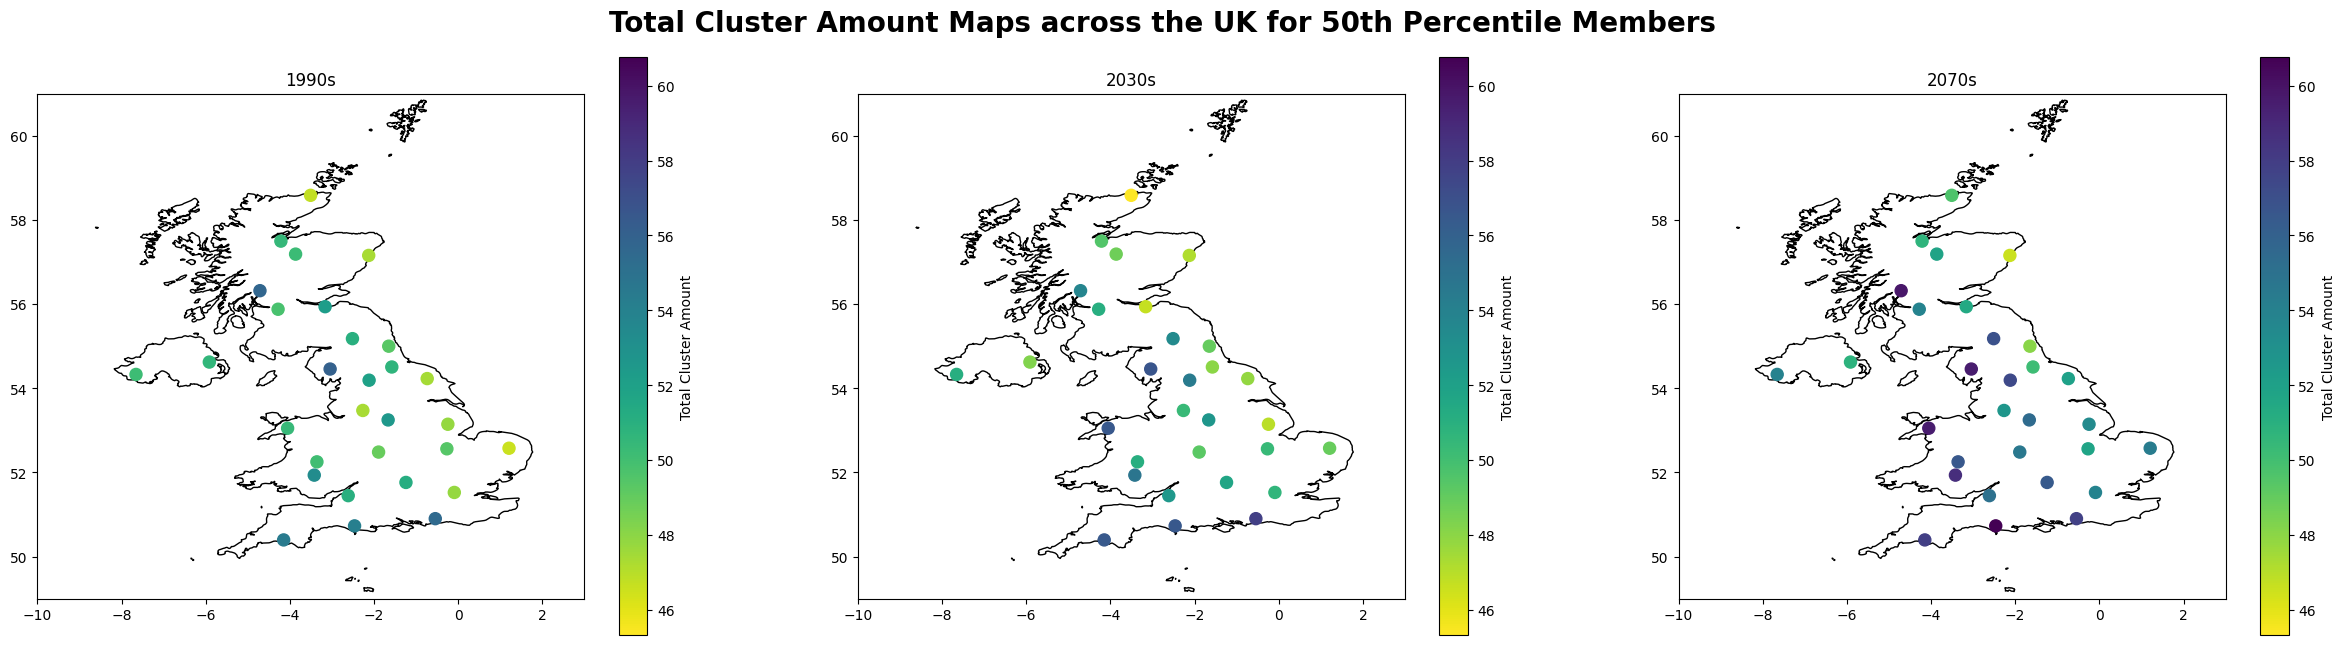

In [24]:
inProj = Proj('epsg:27700')  # British National Grid
outProj = Proj('epsg:4326')  # WGS84

mean_14_1981_2000['Longitude'], mean_14_1981_2000['Latitude'] = transform(inProj, outProj, mean_14_1981_2000['coord1'], mean_14_1981_2000['coord2'])
geometry_1981_2000 = [Point(xy) for xy in zip(mean_14_1981_2000['Latitude'], mean_14_1981_2000['Longitude'])]
gdf_1981_2000 = gpd.GeoDataFrame(mean_14_1981_2000, geometry=geometry_1981_2000)

mean_14_2021_2040['Longitude'], mean_14_2021_2040['Latitude'] = transform(inProj, outProj, mean_14_2021_2040['coord1'], mean_14_2021_2040['coord2'])
geometry_2021_2040 = [Point(xy) for xy in zip(mean_14_2021_2040['Latitude'], mean_14_2021_2040['Longitude'])]
gdf_2021_2040 = gpd.GeoDataFrame(mean_14_2021_2040, geometry=geometry_2021_2040)

mean_14_2061_2080['Longitude'], mean_14_2061_2080['Latitude'] = transform(inProj, outProj, mean_14_2061_2080['coord1'], mean_14_2061_2080['coord2'])
geometry_2061_2080 = [Point(xy) for xy in zip(mean_14_2061_2080['Latitude'], mean_14_2061_2080['Longitude'])]
gdf_2061_2080 = gpd.GeoDataFrame(mean_14_2061_2080, geometry=geometry_2061_2080)

fig, axs = plt.subplots(1, 3, figsize=(30,30))

gdf_uk = gpd.read_file('/content/drive/MyDrive/ne_10m_admin_0_countries.zip')

uk = gdf_uk[gdf_uk['SOVEREIGNT'] == 'United Kingdom']

min_val = min(mean_14_1981_2000['Total Cluster Amount'].min(), 
              mean_14_2021_2040['Total Cluster Amount'].min(), 
              mean_14_2061_2080['Total Cluster Amount'].min())
max_val = max(mean_14_1981_2000['Total Cluster Amount'].max(), 
              mean_14_2021_2040['Total Cluster Amount'].max(), 
              mean_14_2061_2080['Total Cluster Amount'].max())

cmap = mpl.cm.viridis_r

norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

uk.plot(ax=axs[0], color='white', edgecolor='black')

im1 = gdf_1981_2000.plot(ax=axs[0], markersize=75, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[0].set_aspect('equal')
axs[0].set_title('1990s')
axs[0].set_xlim(-10, 3) 
axs[0].set_ylim(49, 61) 

uk.plot(ax=axs[1], color='white', edgecolor='black')
im2 = gdf_2021_2040.plot(ax=axs[1], markersize=75, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[1].set_aspect('equal')
axs[1].set_title('2030s')
axs[1].set_xlim(-10, 3)  
axs[1].set_ylim(49, 61)  

uk.plot(ax=axs[2], color='white', edgecolor='black')
im3 = gdf_2061_2080.plot(ax=axs[2], markersize=75, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[2].set_aspect('equal')
axs[2].set_title('2070s')
axs[2].set_xlim(-10, 3) 
axs[2].set_ylim(49, 61)  

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar1 = fig.colorbar(sm, ax=axs[0], orientation='vertical', shrink=0.25, label='Total Cluster Amount')
cbar2 = fig.colorbar(sm, ax=axs[1], orientation='vertical', shrink=0.25, label='Total Cluster Amount')
cbar3 = fig.colorbar(sm, ax=axs[2], orientation='vertical', shrink=0.25, label='Total Cluster Amount')

title = fig.text(0.5, 0.6, 'Total Cluster Amount Maps across the UK for 50th Percentile Members', 
                 fontsize=20, fontweight='bold', ha='center')

plt.show()


<ipython-input-25-9cbdf438e18e>:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_1981_2000['Longitude'], p95_14_1981_2000['Latitude'] = transform(inProj, outProj, p95_14_1981_2000['coord1'], p95_14_1981_2000['coord2'])
<ipython-input-25-9cbdf438e18e>:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_2021_2040['Longitude'], p95_14_2021_2040['Latitude'] = transform(inProj, outProj, p95_14_2021_2040['coord1'], p95_14_2021_2040['coord2'])
<ipython-input-25-9cbdf438e18e>:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_2061_2080['Longitude'], p95_14_2061_2080['Latitude'] = transform(inProj, outProj, p95_14_2061_2080['coord1'], p95_14_2061_2080['coord2'])


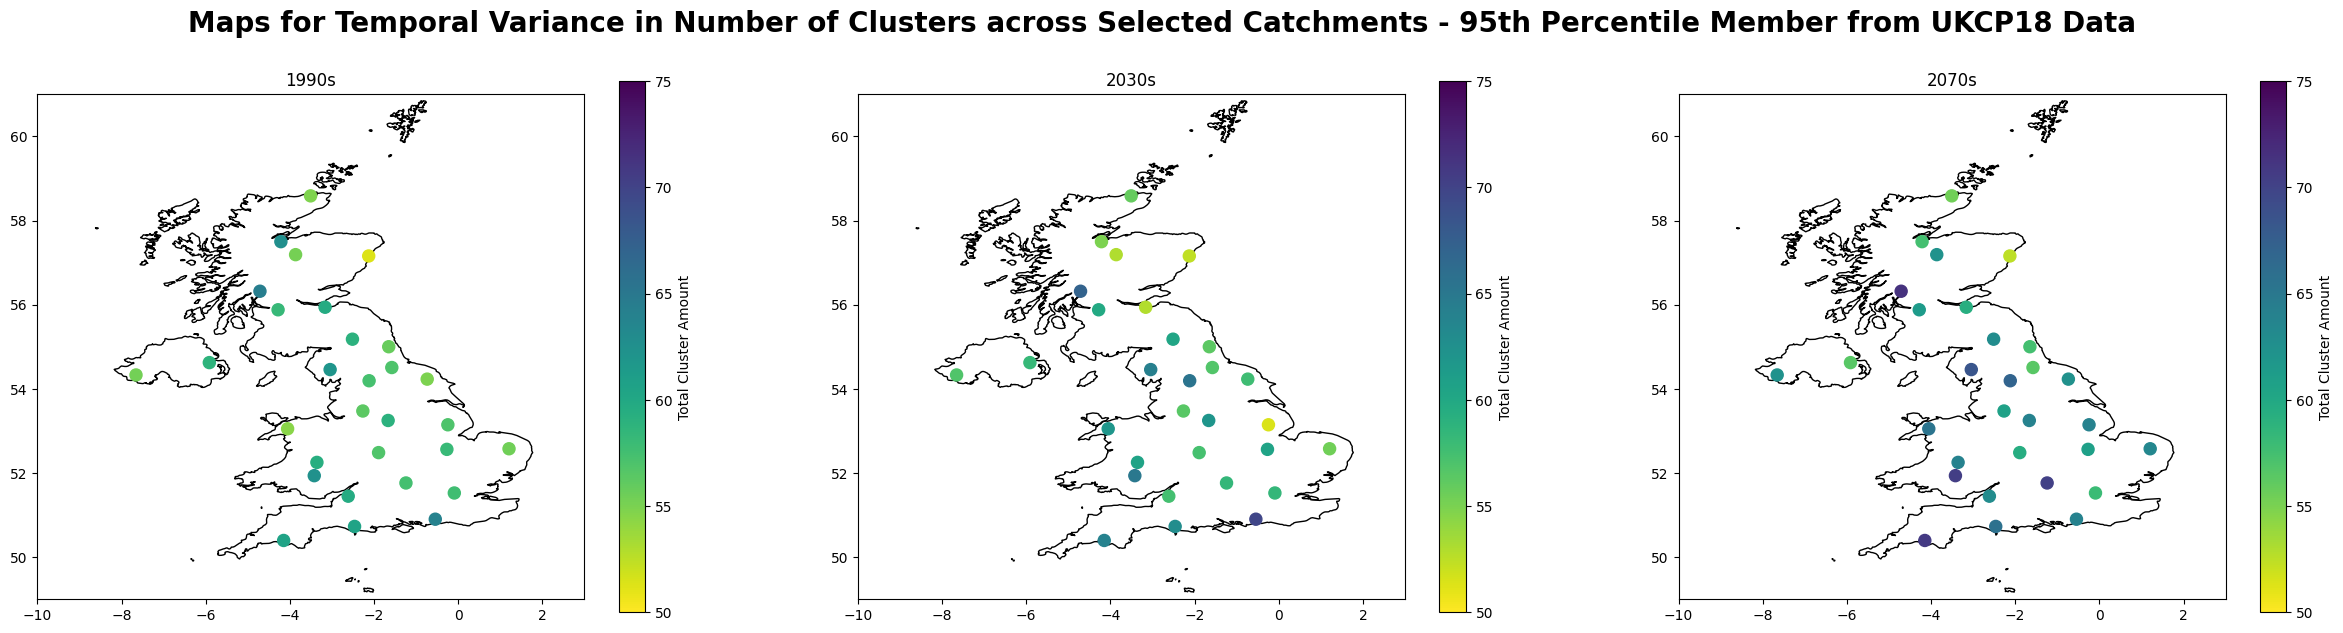

In [25]:
p95_14_1981_2000['Longitude'], p95_14_1981_2000['Latitude'] = transform(inProj, outProj, p95_14_1981_2000['coord1'], p95_14_1981_2000['coord2'])
geometry_1981_2000 = [Point(xy) for xy in zip(p95_14_1981_2000['Latitude'], p95_14_1981_2000['Longitude'])]
gdf_1981_2000 = gpd.GeoDataFrame(p95_14_1981_2000, geometry=geometry_1981_2000)

p95_14_2021_2040['Longitude'], p95_14_2021_2040['Latitude'] = transform(inProj, outProj, p95_14_2021_2040['coord1'], p95_14_2021_2040['coord2'])
geometry_2021_2040 = [Point(xy) for xy in zip(p95_14_2021_2040['Latitude'], p95_14_2021_2040['Longitude'])]
gdf_2021_2040 = gpd.GeoDataFrame(p95_14_2021_2040, geometry=geometry_2021_2040)


p95_14_2061_2080['Longitude'], p95_14_2061_2080['Latitude'] = transform(inProj, outProj, p95_14_2061_2080['coord1'], p95_14_2061_2080['coord2'])
geometry_2061_2080 = [Point(xy) for xy in zip(p95_14_2061_2080['Latitude'], p95_14_2061_2080['Longitude'])]
gdf_2061_2080 = gpd.GeoDataFrame(p95_14_2061_2080, geometry=geometry_2061_2080)

fig, axs = plt.subplots(1, 3, figsize=(30,30))


min_val = (50)
max_val=(75)

cmap = mpl.cm.viridis_r

norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

uk.plot(ax=axs[0], color='white', edgecolor='black')

im1 = gdf_1981_2000.plot(ax=axs[0], markersize=75, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[0].set_aspect('equal')
axs[0].set_title('1990s')
axs[0].set_xlim(-10, 3) 
axs[0].set_ylim(49, 61) 

uk.plot(ax=axs[1], color='white', edgecolor='black')
im2 = gdf_2021_2040.plot(ax=axs[1], markersize=75, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[1].set_aspect('equal')
axs[1].set_title('2030s')
axs[1].set_xlim(-10, 3)  
axs[1].set_ylim(49, 61)  

uk.plot(ax=axs[2], color='white', edgecolor='black')
im3 = gdf_2061_2080.plot(ax=axs[2], markersize=75, column='Total Cluster Amount', cmap=cmap, norm=norm, legend=False)

axs[2].set_aspect('equal')
axs[2].set_title('2070s')
axs[2].set_xlim(-10, 3) 
axs[2].set_ylim(49, 61)  

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar1 = fig.colorbar(sm, ax=axs[0], orientation='vertical', shrink=0.23, label='Total Cluster Amount')
cbar2 = fig.colorbar(sm, ax=axs[1], orientation='vertical', shrink=0.23, label='Total Cluster Amount')
cbar3 = fig.colorbar(sm, ax=axs[2], orientation='vertical', shrink=0.23, label='Total Cluster Amount')

title = fig.text(0.5, 0.6, 'Maps for Temporal Variance in Number of Clusters across Selected Catchments - 95th Percentile Member from UKCP18 Data', 
                 fontsize=20, fontweight='bold', ha='center')

plt.show()

<ipython-input-26-1fa98740de75>:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_1981_2000['Longitude'], p95_14_1981_2000['Latitude'] = transform(inProj, outProj, p95_14_1981_2000['coord1'], p95_14_1981_2000['coord2'])
<ipython-input-26-1fa98740de75>:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_2021_2040['Longitude'], p95_14_2021_2040['Latitude'] = transform(inProj, outProj, p95_14_2021_2040['coord1'], p95_14_2021_2040['coord2'])
<ipython-input-26-1fa98740de75>:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_2061_2080['Longitude'], p95_14_2061_2080['Latitude'] = transform(inProj, outProj, p95_14_2061_2080['coord1'], p95_14_2061_2080['coord2'])


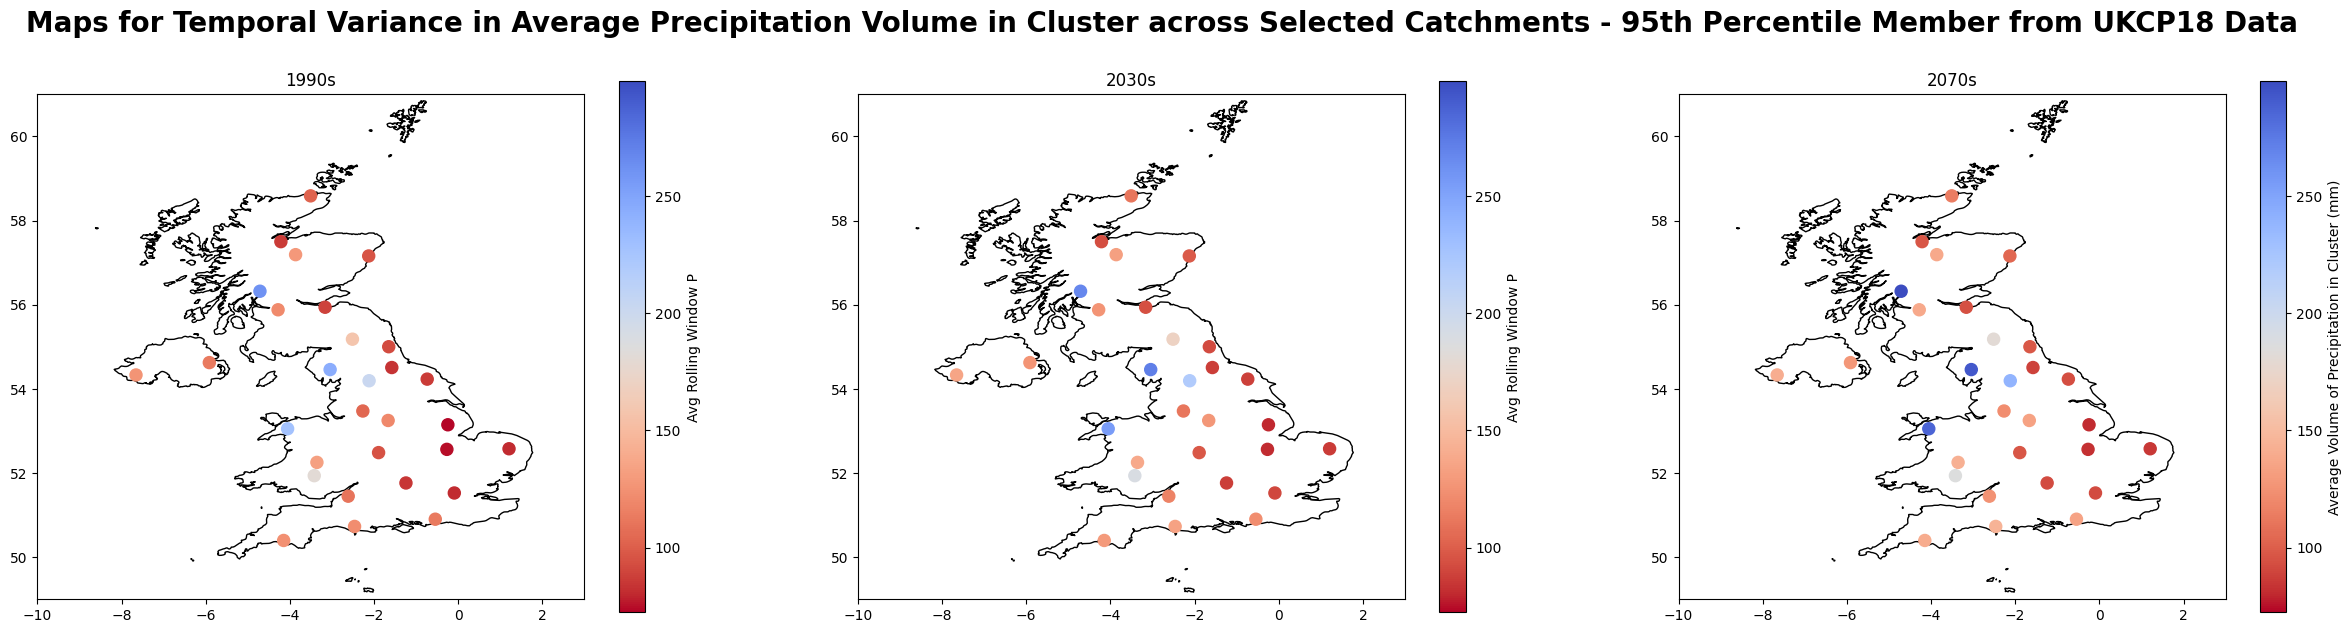

In [26]:
#Same plot but for precipitation volume in cluster
fig, axs = plt.subplots(1, 3, figsize=(30,30))

min_val = min(p95_14_1981_2000['Avg Rolling Window P'].min(), 
              p95_14_2021_2040['Avg Rolling Window P'].min(), 
              p95_14_2061_2080['Avg Rolling Window P'].min())
max_val = max(p95_14_1981_2000['Avg Rolling Window P'].max(), 
              p95_14_2021_2040['Avg Rolling Window P'].max(), 
              p95_14_2061_2080['Avg Rolling Window P'].max())

cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

uk.plot(ax=axs[0], color='white', edgecolor='black')

im1 = gdf_1981_2000.plot(ax=axs[0], markersize=75, column='Avg Rolling Window P', cmap=cmap, norm=norm, legend=False)

axs[0].set_aspect('equal')
axs[0].set_title('1990s')
axs[0].set_xlim(-10, 3) 
axs[0].set_ylim(49, 61) 

uk.plot(ax=axs[1], color='white', edgecolor='black')
im2 = gdf_2021_2040.plot(ax=axs[1], markersize=75, column='Avg Rolling Window P', cmap=cmap, norm=norm, legend=False)

axs[1].set_title('2030s')
axs[1].set_xlim(-10, 3)  
axs[1].set_ylim(49, 61)  

uk.plot(ax=axs[2], color='white', edgecolor='black')
im3 = gdf_2061_2080.plot(ax=axs[2], markersize=75, column='Avg Rolling Window P', cmap=cmap, norm=norm, legend=False)

axs[2].set_aspect('equal')
axs[2].set_title('2070s')
axs[2].set_xlim(-10, 3) 
axs[2].set_ylim(49, 61)  

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar1 = fig.colorbar(sm, ax=axs[0], orientation='vertical', shrink=0.23, label='Avg Rolling Window P')
cbar2 = fig.colorbar(sm, ax=axs[1], orientation='vertical', shrink=0.23, label='Avg Rolling Window P')
cbar3 = fig.colorbar(sm, ax=axs[2], orientation='vertical', shrink=0.23, label='Average Volume of Precipitation in Cluster (mm)')

title = fig.text(0.5, 0.6, 'Maps for Temporal Variance in Average Precipitation Volume in Cluster across Selected Catchments - 95th Percentile Member from UKCP18 Data', 
                 fontsize=20, fontweight='bold', ha='center')

plt.show()


<ipython-input-27-55be7a6d3a9b>:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_1981_2000['Longitude'], p95_14_1981_2000['Latitude'] = transform(inProj, outProj, p95_14_1981_2000['coord1'], p95_14_1981_2000['coord2'])
<ipython-input-27-55be7a6d3a9b>:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_2021_2040['Longitude'], p95_14_2021_2040['Latitude'] = transform(inProj, outProj, p95_14_2021_2040['coord1'], p95_14_2021_2040['coord2'])
<ipython-input-27-55be7a6d3a9b>:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p95_14_2061_2080['Longitude'], p95_14_2061_2080['Latitude'] = transform(inProj, outProj, p95_14_2061_2080['coord1'], p95_14_2061_2080['coord2'])


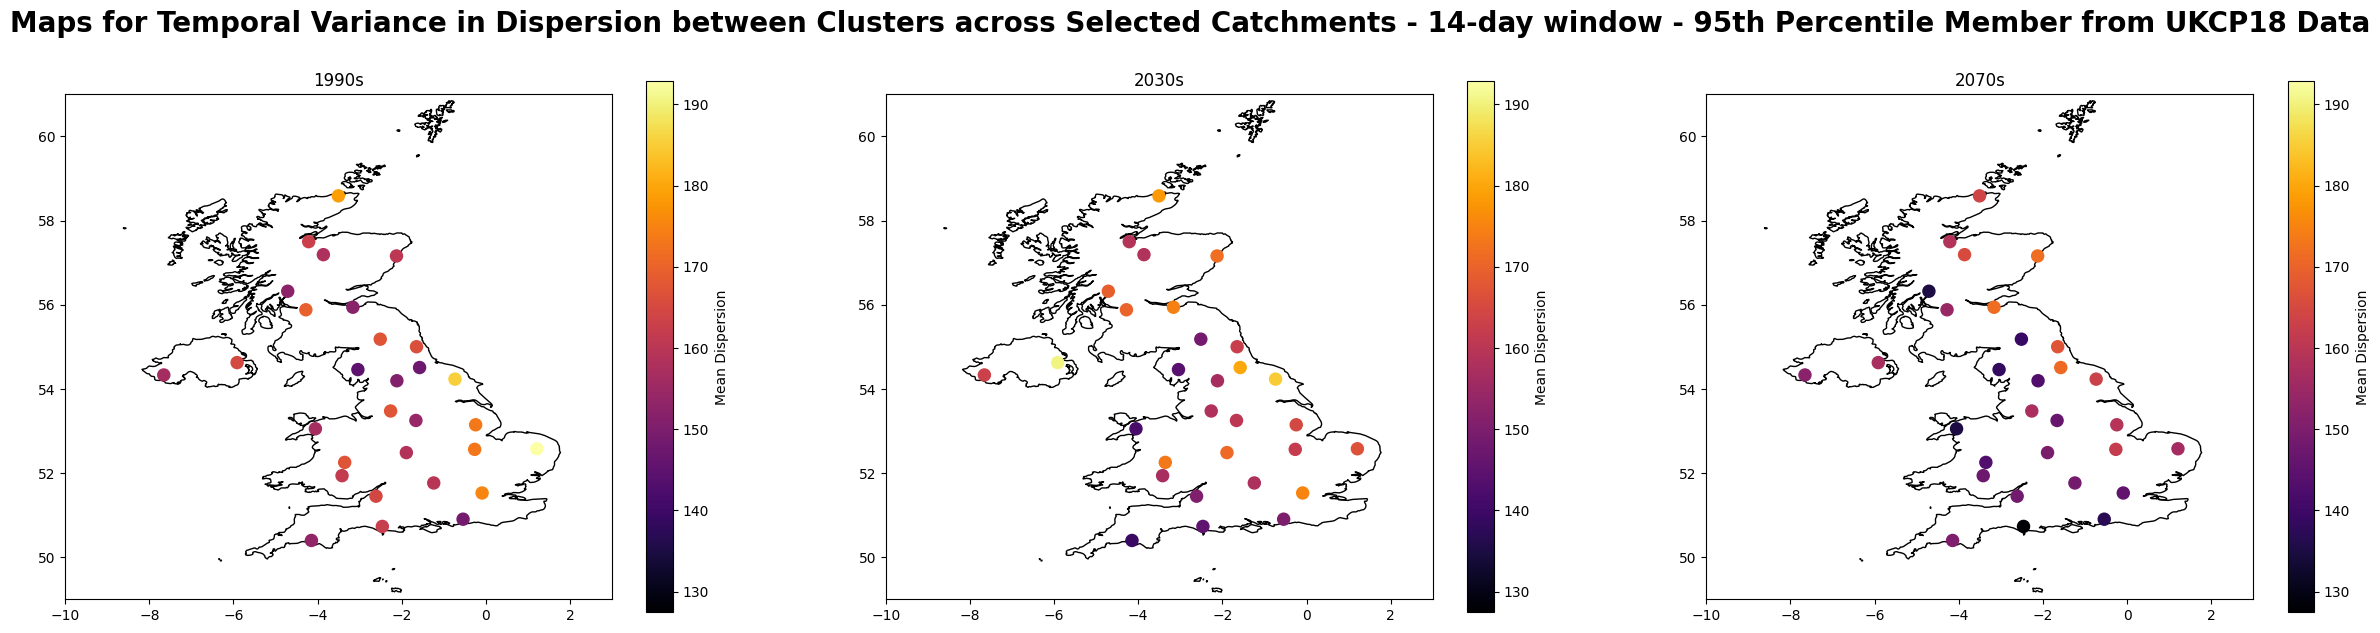

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(30,30))

min_val = min(p95_14_1981_2000['Mean Dispersion'].min(), 
              p95_14_2021_2040['Mean Dispersion'].min(), 
              p95_14_2061_2080['Mean Dispersion'].min())
max_val = max(p95_14_1981_2000['Mean Dispersion'].max(), 
              p95_14_2021_2040['Mean Dispersion'].max(), 
              p95_14_2061_2080['Mean Dispersion'].max())

cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

uk.plot(ax=axs[0], color='white', edgecolor='black')

im1 = gdf_1981_2000.plot(ax=axs[0], markersize=75, column='Mean Dispersion', cmap=cmap, norm=norm, legend=False)

axs[0].set_aspect('equal')
axs[0].set_title('1990s')
axs[0].set_xlim(-10, 3) 
axs[0].set_ylim(49, 61) 

uk.plot(ax=axs[1], color='white', edgecolor='black')
im2 = gdf_2021_2040.plot(ax=axs[1], markersize=75, column='Mean Dispersion', cmap=cmap, norm=norm, legend=False)

axs[1].set_title('2030s')
axs[1].set_xlim(-10, 3)  
axs[1].set_ylim(49, 61)  

uk.plot(ax=axs[2], color='white', edgecolor='black')
im3 = gdf_2061_2080.plot(ax=axs[2], markersize=75, column='Mean Dispersion', cmap=cmap, norm=norm, legend=False)

axs[2].set_aspect('equal')
axs[2].set_title('2070s')
axs[2].set_xlim(-10, 3) 
axs[2].set_ylim(49, 61)  

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar1 = fig.colorbar(sm, ax=axs[0], orientation='vertical', shrink=0.23, label='Mean Dispersion')
cbar2 = fig.colorbar(sm, ax=axs[1], orientation='vertical', shrink=0.23, label='Mean Dispersion')
cbar3 = fig.colorbar(sm, ax=axs[2], orientation='vertical', shrink=0.23, label='Mean Dispersion')

title = fig.text(0.5, 0.6, 'Maps for Temporal Variance in Dispersion between Clusters across Selected Catchments - 14-day window - 95th Percentile Member from UKCP18 Data', 
                 fontsize=20, fontweight='bold', ha='center')

plt.show()

<ipython-input-28-c872a2c26be0>:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  percentiles_14_2061_2080['Longitude'], percentiles_14_2061_2080['Latitude'] = transform(inProj, outProj, percentiles_14_2061_2080['coord1'], percentiles_14_2061_2080['coord2'])
<ipython-input-28-c872a2c26be0>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-28-c872a2c26be0>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-28-c872a2c26be0>:32: MatplotlibDeprecationWarning: The g

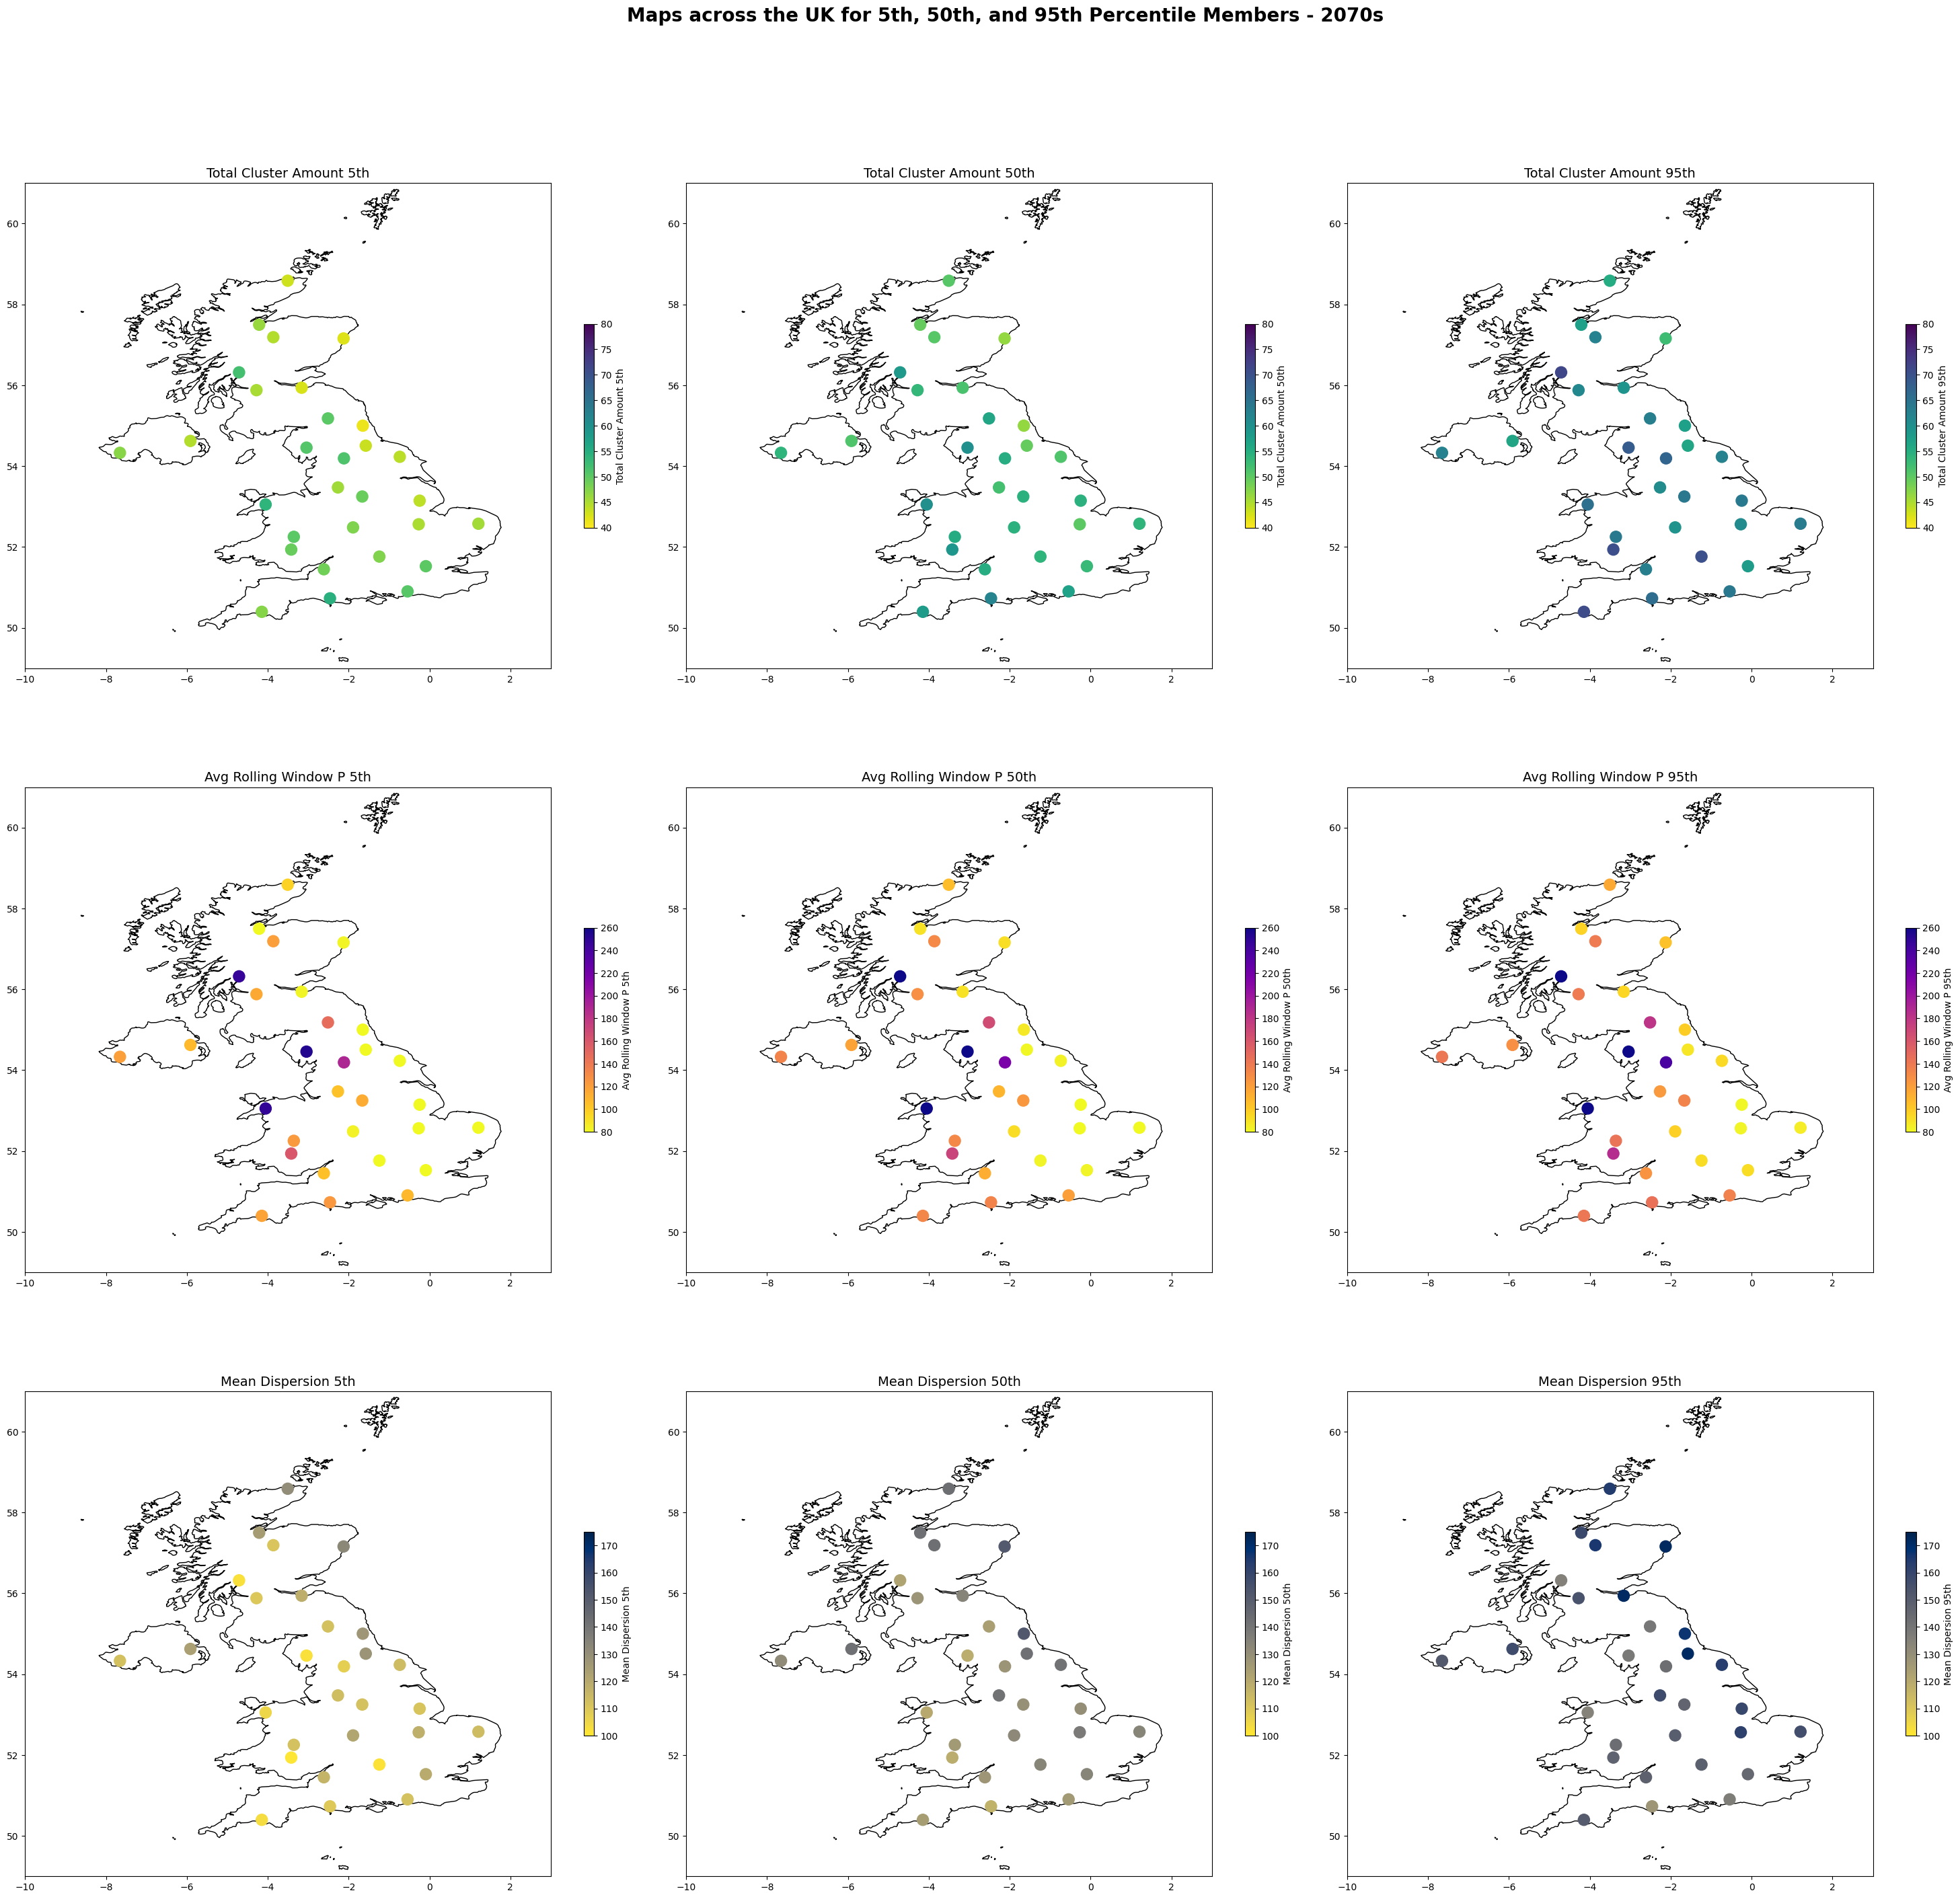

In [28]:
#Percentile member maps for all 3 metrics
percentiles_14_2061_2080 = all_14Window_2061_2080.groupby('Location/Timeframe').agg({
    'Total Cluster Amount': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Avg Rolling Window P': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Mean Dispersion': [lambda x: np.percentile(x, 5), 'median', lambda x: np.percentile(x, 95)],
    'Coordinates': 'first' 
}).reset_index()

percentiles_14_2061_2080.columns = ['Location/Timeframe', 
                                    'Total Cluster Amount 5th', 'Total Cluster Amount 50th', 'Total Cluster Amount 95th',
                                    'Avg Rolling Window P 5th', 'Avg Rolling Window P 50th', 'Avg Rolling Window P 95th',
                                    'Mean Dispersion 5th', 'Mean Dispersion 50th', 'Mean Dispersion 95th', 
                                    'Coordinates']

percentiles_14_2061_2080[['coord1', 'coord2']] = pd.DataFrame(percentiles_14_2061_2080['Coordinates'].tolist(), index=percentiles_14_2061_2080.index)
percentiles_14_2061_2080['Longitude'], percentiles_14_2061_2080['Latitude'] = transform(inProj, outProj, percentiles_14_2061_2080['coord1'], percentiles_14_2061_2080['coord2'])
geometry_2061_2080 = [Point(xy) for xy in zip(percentiles_14_2061_2080['Latitude'], percentiles_14_2061_2080['Longitude'])]
gdf_2061_2080 = gpd.GeoDataFrame(percentiles_14_2061_2080, geometry=geometry_2061_2080)

fig, axs = plt.subplots(3, 3, figsize=(30,30))

metrics = ['Total Cluster Amount', 'Avg Rolling Window P', 'Mean Dispersion']
percentiles = ['5th', '50th', '95th']

cmaps = ['viridis_r', 'plasma_r', 'cividis_r']

min_values = [40, 80, 100]  
max_values = [80, 260, 175]  

for i, metric in enumerate(metrics):
    for j, percentile in enumerate(percentiles):
        cmap = mpl.cm.get_cmap(cmaps[i])

        norm = mpl.colors.Normalize(vmin=min_values[i], vmax=max_values[i])

        uk.plot(ax=axs[i, j], color='white', edgecolor='black')
        im = gdf_2061_2080.plot(ax=axs[i, j], markersize=150, column=f'{metric} {percentile}', cmap=cmap, norm=norm, legend=False)

        axs[i, j].set_title(f'{metric} {percentile}', fontsize=14)
        axs[i, j].set_xlim(-10, 3)  
        axs[i, j].set_ylim(49, 61)  

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = fig.colorbar(sm, ax=axs[i, j], orientation='vertical', shrink=0.3, label=f'{metric} {percentile}')

title = fig.suptitle('Maps across the UK for 5th, 50th, and 95th Percentile Members - 2070s', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()



In [29]:
percent_percentiles_ClusterAmount_df = percenttotalcluster_df.quantile([0.05, 0.5, 0.95], axis=1).T
percent_percentiles_AvgRollingP_df = percentAvgRollingP_df.quantile([0.05, 0.5, 0.95], axis=1).T
percent_percentiles_Dispersion_df = percent_mean_dispersion_df.quantile([0.05, 0.5, 0.95], axis=1).T

percent_percentiles_ClusterAmount_df.columns = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']
percent_percentiles_AvgRollingP_df.columns = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']
percent_percentiles_Dispersion_df.columns = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']

percent_percentiles_Dispersion_df = percent_percentiles_Dispersion_df.reset_index(drop=True)
percent_percentiles_ClusterAmount_df = percent_percentiles_ClusterAmount_df.reset_index(drop=True)
percent_percentiles_AvgRollingP_df = percent_percentiles_AvgRollingP_df.reset_index(drop=True)

percent_percentiles_Dispersion_df = pd.concat([percent_percentiles_Dispersion_df, gdf_2061_2080[['Longitude', 'Latitude']]], axis=1)
percent_percentiles_ClusterAmount_df = pd.concat([percent_percentiles_ClusterAmount_df, gdf_2061_2080[['Longitude', 'Latitude']]], axis=1)
percent_percentiles_AvgRollingP_df = pd.concat([percent_percentiles_AvgRollingP_df, gdf_2061_2080[['Longitude', 'Latitude']]], axis=1)


<ipython-input-30-a4fbf9eb99bc>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-30-a4fbf9eb99bc>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-30-a4fbf9eb99bc>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmaps[i])
<ipython-input-30-a4fbf9eb99bc>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be rem

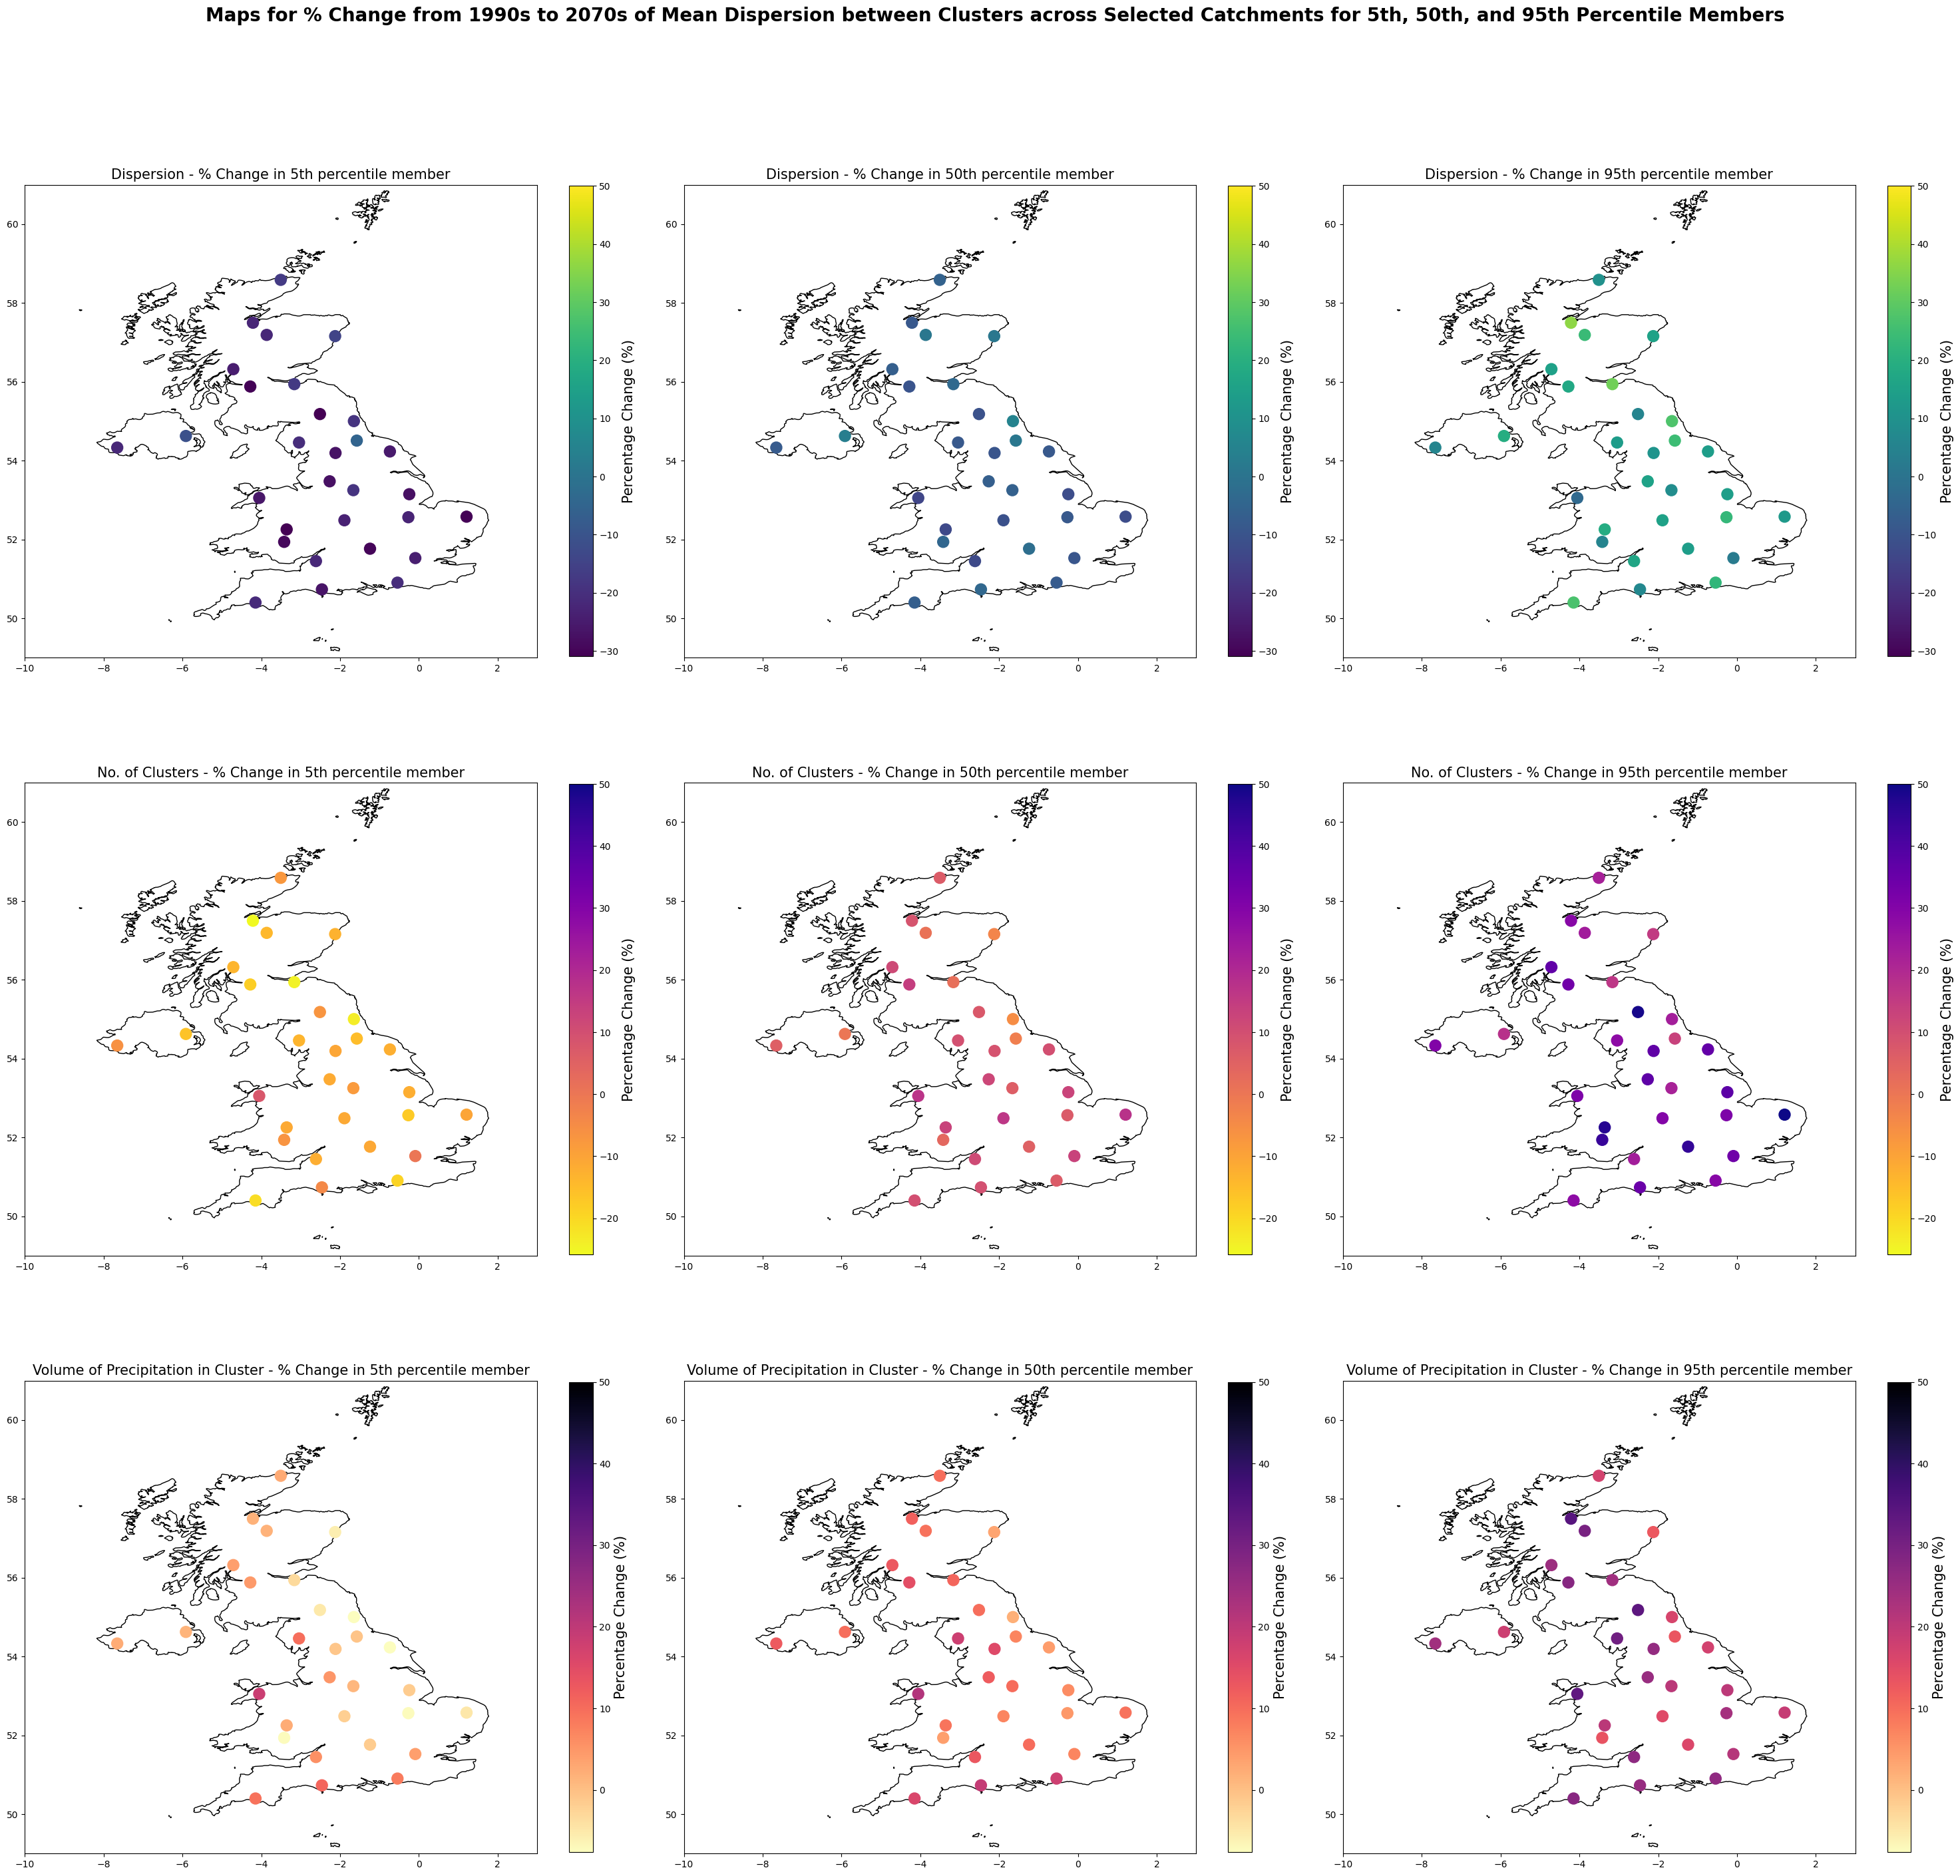

In [30]:
#Percentage Change maps for dispersion
fig, axs = plt.subplots(3, 3, figsize=(30, 30))

metrics = ['Dispersion', 'No. of Clusters', 'Volume of Precipitation in Cluster']
percentile_dfs = [percent_percentiles_Dispersion_df, percent_percentiles_ClusterAmount_df, percent_percentiles_AvgRollingP_df]
percentiles = ['% Change in 5th percentile member', '% Change in 50th percentile member', '% Change in 95th percentile member']

cmaps = ['viridis', 'plasma_r', 'magma_r']

min_values = [df.min().min() for df in percentile_dfs]
max_values = [df.max().max() for df in percentile_dfs]

for i, metric in enumerate(metrics):
    for j, percentile in enumerate(percentiles):

        cmap = mpl.cm.get_cmap(cmaps[i])

        norm = mpl.colors.Normalize(vmin=min_values[i], vmax=50)

        uk.plot(ax=axs[i, j], color='white', edgecolor='black')
        im = axs[i, j].scatter(percentile_dfs[i]['Latitude'], percentile_dfs[i]['Longitude'], s=150, c=percentile_dfs[i][percentile], cmap=cmap, norm=norm)

        axs[i, j].set_title(f'{metric} - {percentile}', fontsize=15)
        axs[i, j].set_xlim(-10, 3)  
        axs[i, j].set_ylim(49, 61)  

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = fig.colorbar(sm, ax=axs[i, j], orientation='vertical', shrink=0.7)
        cbar.set_label('Percentage Change (%)', fontsize=15)

title = fig.suptitle('Maps for % Change from 1990s to 2070s of Mean Dispersion between Clusters across Selected Catchments for 5th, 50th, and 95th Percentile Members', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [31]:
# Additional min/max Calculations
average_min_dispersion_1981_2000 = all_14Window_1981_2000['Min Dispersion'].mean()
average_max_dispersion_1981_2000 = all_14Window_1981_2000['Max Dispersion'].mean()
average_max_TP_1981_2000 = all_14Window_1981_2000['Peak TP'].mean()

average_min_dispersion_2021_2040 = all_14Window_2021_2040['Min Dispersion'].mean()
average_max_dispersion_2021_2040 = all_14Window_2021_2040['Max Dispersion'].mean()
average_max_TP_2021_2040 = all_14Window_2021_2040['Peak TP'].mean()

average_min_dispersion_2061_2080 = all_14Window_2061_2080['Min Dispersion'].mean()
average_max_dispersion_2061_2080 = all_14Window_2061_2080['Max Dispersion'].mean()
average_max_TP_2061_2080 = all_14Window_2061_2080['Peak TP'].mean()

print('1981-2000 time period:\n', 
      'Average Min Dispersion:', average_min_dispersion_1981_2000,
      '\nAverage Max Dispersion:', average_max_dispersion_1981_2000,
      '\nAverage Max TP:', average_max_TP_1981_2000)

print('\n2021-2040 time period:\n', 
      'Average Min Dispersion:', average_min_dispersion_2021_2040,
      '\nAverage Max Dispersion:', average_max_dispersion_2021_2040,
      '\nAverage Max TP:', average_max_TP_2021_2040)

print('\n2061-2080 time period:\n', 
      'Average Min Dispersion:', average_min_dispersion_2061_2080,
      '\nAverage Max Dispersion:', average_max_dispersion_2061_2080,
      '\nAverage Max TP:', average_max_TP_2061_2080)


1981-2000 time period:
 Average Min Dispersion: 3.638888888888889 
Average Max Dispersion: 666.3305555555555 
Average Max TP: 75.56036195833333

2021-2040 time period:
 Average Min Dispersion: 3.602777777777778 
Average Max Dispersion: 657.4638888888888 
Average Max TP: 81.5791192111111

2061-2080 time period:
 Average Min Dispersion: 3.2222222222222223 
Average Max Dispersion: 637.9611111111111 
Average Max TP: 91.93147898888888


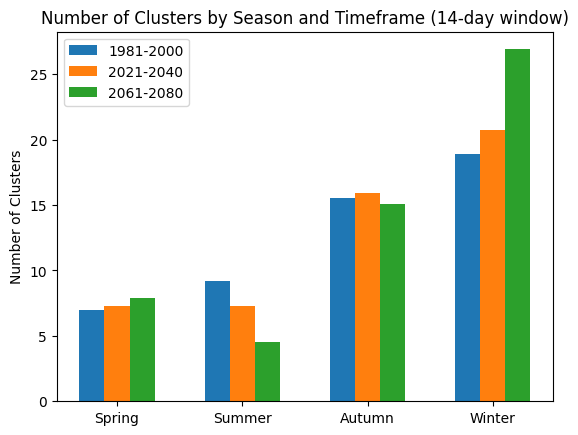

In [32]:
# Seasonality Bar Chart (cluster count)
seasons = ['Spring Clusters', 'Summer Clusters', 'Autumn Clusters', 'Winter Clusters']

time_period1 = [all_14Window_1981_2000[season].mean() for season in seasons]
time_period2 = [all_14Window_2021_2040[season].mean() for season in seasons]
time_period3 = [all_14Window_2061_2080[season].mean() for season in seasons]

labels = ['Spring', 'Summer', 'Autumn', 'Winter']
x = np.arange(len(labels)) 
width = 0.2  
fig, ax = plt.subplots()

rects1 = ax.bar(x - width, time_period1, width, label='1981-2000')
rects2 = ax.bar(x, time_period2, width, label='2021-2040')
rects3 = ax.bar(x + width, time_period3, width, label='2061-2080')

ax.set_ylabel('Number of Clusters')
ax.set_title('Number of Clusters by Season and Timeframe (14-day window)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()



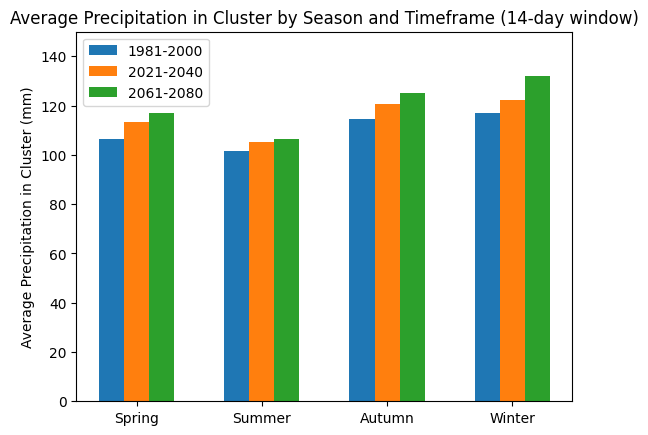

In [33]:
# Second seasonality bar chart (intensity in cluster)
seasons = ['Avg Spring Rolling Window P', 'Avg Summer Rolling Window P', 'Avg Autumn Rolling Window P', 'Avg Winter Rolling Window P']

time_period1 = [all_14Window_1981_2000[season].mean() for season in seasons]
time_period2 = [all_14Window_2021_2040[season].mean() for season in seasons]
time_period3 = [all_14Window_2061_2080[season].mean() for season in seasons]

labels = ['Spring', 'Summer', 'Autumn', 'Winter']
x = np.arange(len(labels)) 
width = 0.2 

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, time_period1, width, label='1981-2000')
rects2 = ax.bar(x, time_period2, width, label='2021-2040')
rects3 = ax.bar(x + width, time_period3, width, label='2061-2080')

ax.set_ylabel('Average Precipitation in Cluster (mm)')
ax.set_title('Average Precipitation in Cluster by Season and Timeframe (14-day window)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 150])
ax.legend()

plt.show()


In [34]:
percentage_changes = []
for i in range(len(seasons)):
    percentage_change = ((time_period3[i] - time_period1[i]) / time_period1[i]) * 100
    percentage_changes.append(percentage_change)

for i in range(len(seasons)):
    print("Percentage Change in", seasons[i], "between 2061-2080 and 1981-2000:", percentage_changes[i])


Percentage Change in Avg Spring Rolling Window P between 2061-2080 and 1981-2000: 9.733131604152062
Percentage Change in Avg Summer Rolling Window P between 2061-2080 and 1981-2000: 4.618771495751439
Percentage Change in Avg Autumn Rolling Window P between 2061-2080 and 1981-2000: 9.387976852766927
Percentage Change in Avg Winter Rolling Window P between 2061-2080 and 1981-2000: 12.9631671846613
